*Aprenentatge Computacional*

**Autor:**
- Sebastian Malbaceda Leyva (1681519)


# Cas Kaggle - Student Alcohol Consumption

En aquesta pràctica s'abordarà la creació d'un model d'aprenentatge computacional enfocat en classificació. Aquest model s'encarregarà de predir el nivell de consum d'alcohol dels estudiants als caps de setmana. Per poder aconseguir això, s'ha pogut recollir una sèrie de dades d'un institut. Aquestes dades són una sèrie de característiques de cada estudiant on es pot trobar informació tant relacionada amb l'ambient on es troba com amb el rendiment acadèmic que ha demostrat.

Per poder obtenir el millor model possible, seguirem una sèrie de passos on analitzarem les dades obtingudes, les processarem, triarem una sèrie de models candidats per entrenar i analitzarem els resultats obtinguts, decidint el millor classificador.

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades.

In [796]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import StandardScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from scipy.stats import chi2_contingency

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

### 1. EDA (exploratory data analysis)

Previ a observar el dataset, hem de carregar tot el necessari per poder començar a treballar.

A la pàgina del cas Kaggle es pot trobar informació dels datasets que es carreguen. El que faré és utilitzar els dos datasets que pertanyen a dos grups d'alumnes d'un cert institut. Un d'ells és el de la classe de matemàtiques i l'altre és el dels alumnes de portuguès.

Per a l'anàlisi de dades, el que es farà serà utilitzar els dos datasets de manera concatenada, és a dir, juntarem tots dos datasets per poder tenir un model més estable. Segons certes aclaracions a la pàgina de Kaggle, hi ha alumnes que poden pertànyer a les dues classes, així que s'aconsella tractar de filtrar aquests alumnes. Es menciona breument que aquells alumnes amb atributs idèntics són els que pertanyen a totes dues classes. Potser no és del tot clar, però considerarem que si un registre és exactament idèntic a un altre, serà eliminat, quedant-nos només amb un d'ells. Per tant, el que farem serà concatenar els datasets i eliminar els duplicats.

In [797]:
dataset_math = pd.read_csv("data/student-mat.csv")
dataset_por = pd.read_csv("data/student-por.csv")

dataset = pd.concat([dataset_math, dataset_por], ignore_index=True)
dataset = dataset.drop_duplicates()

A continuació es farà la partició del dataset resultant considerant la característica objectiu a predir. En aquest cas, com es suggereix al títol, ens centrarem a predir el nivell d'alcohol, de manera que analitzarem aquelles característiques que influeixen en aquest.

Hi ha dues característiques principals que fan referència al consum, com per exemple Walc (consum d'alcohol els caps de setmana) i, per altra banda, Dalc, que fa referència al nivell de consum d'alcohol els dies laborals.

En aquesta pràctica ens centrarem a predir el Walc, ja que és més probable que tingui un impacte més gran en estudiants joves. Descartem Dalc perquè potser no tots els estudiants treballen des de joves o no té massa pes si ens referim als dies hàbils.

Veurem graficament el dataset abants de fer la particio en test i train

Recompte de cada classe:
Walc
1    398
2    235
3    200
4    138
5     73


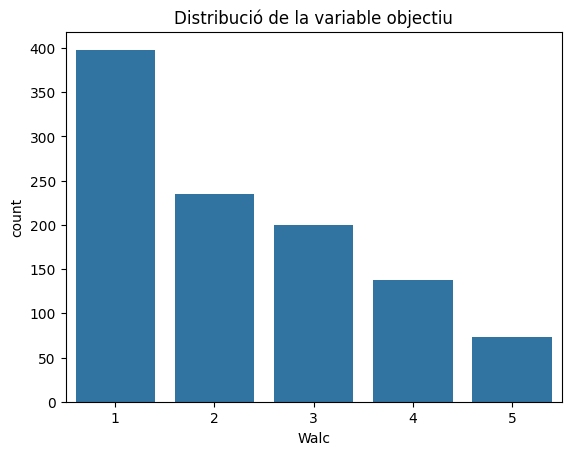

In [798]:
class_counts = dataset['Walc'].value_counts()
print("Recompte de cada classe:")
print(class_counts.to_string())

sns.countplot(x='Walc', data=dataset)
plt.title('Distribució de la variable objectiu')
plt.show()

Vist la proporció dels 5 nivells de consum, observem clarament un desbalanç considerable i una forta tendència a haver-hi més alumnes que consumeixen poc alcohol (Walc = 1). El nivell 1 indica baix consum, mentre que el nivell 5 indica consum alt.

En tenir molt poques mostres d'alumnes que consumeixen molt alcohol, prendrem la decisió de destinar un 75% de les dades al train i un 25% a la part de test, a més a més de que es farà una partició equilibrada i es consideraràn tècniques i estratègies de balanceig.

In [799]:
train, test = train_test_split(dataset, train_size=0.75, stratify=dataset['Walc'], random_state=42)

dataset.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


Procedirem a mostrar les dimensions obtingudes tant del dataset amb el qual treballem com del train que analitzarem i del test.

In [800]:
print("El nombre de mostres que tenim a la base de dades és de",dataset.shape[0])
print("El nombre de atributs que tenim a la base de dades és de",dataset.shape[1])

print("El nombre de mostres que tenim al train és de",train.shape[0])
print("El nombre de atributs que tenim al train és de",train.shape[1])

print("El nombre de mostres que tenim al test és de",test.shape[0])
print("El nombre de atributs que tenim al test és de",test.shape[1])

El nombre de mostres que tenim a la base de dades és de 1044
El nombre de atributs que tenim a la base de dades és de 33
El nombre de mostres que tenim al train és de 783
El nombre de atributs que tenim al train és de 33
El nombre de mostres que tenim al test és de 261
El nombre de atributs que tenim al test és de 33


Tenim una mida de mostres una mica justa per part del dataset complet i d'igual manera com s'ha mencionat, el train i el test seràn proporcionals al dataset.

Comptatge de cada classe:
Walc
1    298
2    176
3    150
4    104
5     55
Comptatge de cada classe:
Walc
1    100
2     59
3     50
4     34
5     18


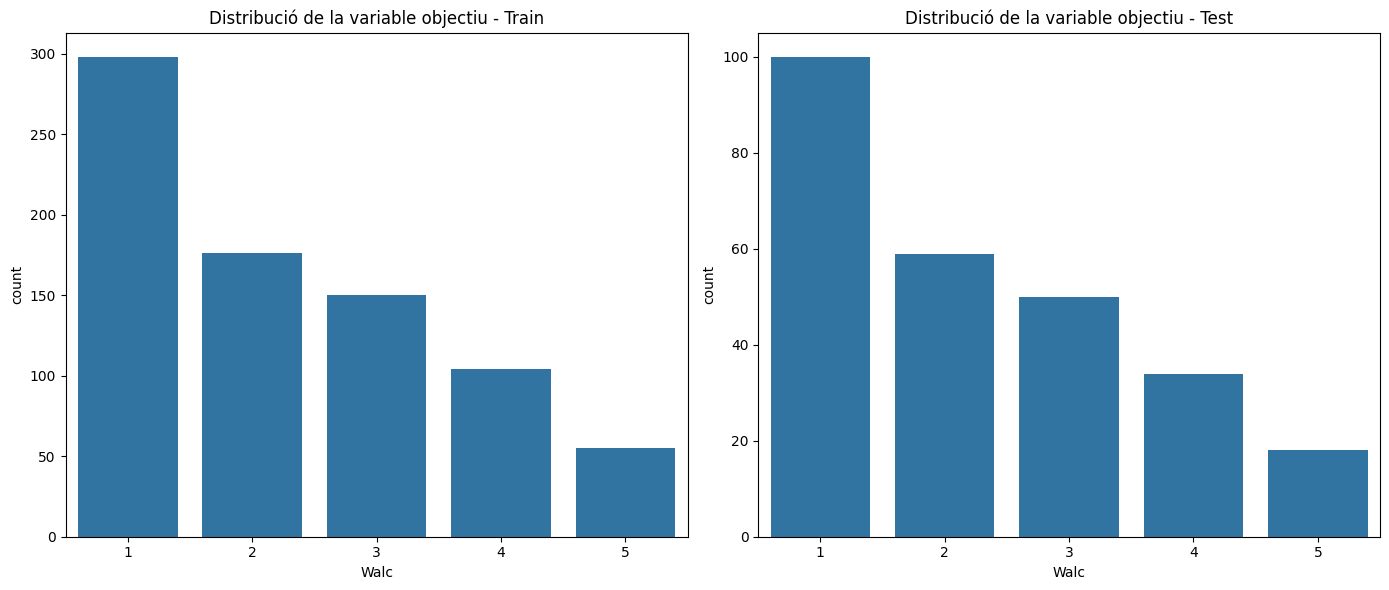

In [801]:
class_counts = train['Walc'].value_counts()
print("Comptatge de cada classe:")
print(class_counts.to_string())

class_counts = test['Walc'].value_counts()
print("Comptatge de cada classe:")
print(class_counts.to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='Walc', data=train, ax=axes[0])
axes[0].set_title('Distribució de la variable objectiu - Train')

sns.countplot(x='Walc', data=test, ax=axes[1])
axes[1].set_title('Distribució de la variable objectiu - Test')

plt.tight_layout()
plt.show()

Es pot veure que disposem de 33 atributs diferents amb un total de 783 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. Com que no esta gens equilibrat, optarem per entrenar models balancellats i/o una generació sintètica de mostres. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del cosnum.

In [802]:
print("Informació de cada atribut:")
print(dataset.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non

El dataset a treballar conté una sèrie s'atributs que pertanyen a dos grups d'estudiants de les matèries de anglés i portuguès:

- **school**: Fa referència a l'escola on estudia l'estudiant. És una variable binària que pot tenir dos valors possibles: 'GP' per Gabriel Pereira o 'MS' per Mousinho da Silveira, que són els noms de dues escoles diferents.

- **sex**: Indica el sexe de l'estudiant. És una variable binària on 'F' representa una dona i 'M' un home.

- **age**: És l'edat de l'estudiant, una variable numèrica que oscil·la entre els 15 i els 22 anys.

- **address**: Tipus d'adreça de la llar de l'estudiant. Aquesta variable és binària, amb 'U' per indicar que l'estudiant viu en una zona urbana i 'R' per indicar una zona rural.

- **famsize**: Fa referència a la mida de la família de l'estudiant. És també una variable binària on 'LE3' indica que la família té tres membres o menys i 'GT3' significa que la família té més de tres membres.

- **Pstatus**: Indica l'estat de convivència dels pares de l'estudiant. Pot ser 'T' per pares que viuen junts o 'A' per pares separats.

- **Medu**: Aquesta variable indica el nivell educatiu de la mare de l'estudiant. És numèrica i pot prendre els següents valors: 0 per cap educació, 1 per educació primària (fins al quart grau), 2 per educació de 5è a 9è grau, 3 per educació secundària, o 4 per educació superior.

- **Fedu**: Al igual que la variable anterior, Fedu indica el nivell educatiu del pare de l'estudiant amb els mateixos valors: 0 per cap educació, 1 per educació primària, 2 per educació de 5è a 9è grau, 3 per educació secundària, i 4 per educació superior.

- **Mjob**: La professió de la mare de l'estudiant. És una variable nominal que pot ser una de les següents: 'teacher' (mestra), relacionada amb la salut (salut), 'services' (com serveis civils com la policia o administració), 'at_home' (a casa), o 'other' (altres).

- **Fjob**: Fa referència a la professió del pare de l'estudiant, amb les mateixes opcions que la variable Mjob: 'teacher', 'health', 'services', 'at_home' i 'other'.

- **reason**: Motiu pel qual l'estudiant va triar aquesta escola en particular. Pot ser un dels següents: 'home' (perquè està a prop de casa), 'reputation' (per la bona reputació de l'escola), 'course' (preferència per l'assignatura), o 'other' (altres raons).

- **guardian**: Aquesta variable indica qui és el tutor legal de l'estudiant. Pot ser 'mother' (mare), 'father' (pare), o 'other' (un altre tutor).

- **traveltime**: Temps de desplaçament entre la casa i l'escola. És una variable numèrica on el valor pot ser 1 (menys de 15 minuts), 2 (de 15 a 30 minuts), 3 (de 30 minuts a 1 hora), o 4 (més d'1 hora).

- **studytime**: Temps d'estudi setmanal de l'estudiant. És també una variable numèrica amb els següents valors: 1 (menys de 2 hores), 2 (de 2 a 5 hores), 3 (de 5 a 10 hores), o 4 (més de 10 hores).

- **failures**: Nombre de suspensos en anteriors classes. És una variable numèrica on el valor pot ser 1, 2, o 3 si el nombre de suspensos és menor que 3, i 4 si l'estudiant ha suspès 3 o més classes.

- **schoolsup**: Indica si l'estudiant rep suport educatiu extra fora de les hores lectives. És binària, amb 'sí' o 'no'.

- **famsup**: Fa referència a si l'estudiant rep suport educatiu per part de la seva família. Aquesta també és una variable binària amb les opcions 'sí' o 'no'.

- **paid**: Aquesta variable indica si l'estudiant participa en classes pagades extra relacionades amb la matèria del curs, ja sigui Matemàtiques o Portuguès. També és binària, amb 'sí' o 'no'.

- **activities**: Indica si l'estudiant participa en activitats extraescolars. És una variable binària amb 'sí' o 'no'.

- **nursery**: Fa referència si l'estudiant va assistir a una escola bressol abans de començar l'escola primària. Pot ser 'sí' o 'no'.

- **higher**: Indica si l'estudiant té la intenció de continuar els seus estudis amb educació superior. També és binària, amb 'sí' o 'no'.

- **internet**: Aquesta variable indica si l'estudiant té accés a Internet a casa seva. És binària, amb 'sí' o 'no'.

- **romantic**: Indica si l'estudiant està en una relació romàntica. És binària, amb 'sí' o 'no'.

- **famrel**: Fa referència a la qualitat de les relacions familiars de l'estudiant. Aquesta és una variable numèrica, amb una escala de 1 (molt dolent) a 5 (excel·lent).

- **freetime**: Temps lliure que l'estudiant té després de l'escola. És una variable numèrica, amb una escala de 1 (molt baix) a 5 (molt alt).

- **goout**: Indica com d'apassionat és l'estudiant de sortir amb els seus amics. Aquesta variable numèrica té una escala de 1 (molt poc) a 5 (molt sovint).

- **Dalc**: Indica el consum d'alcohol de l'estudiant en dies laborables. És una variable numèrica, amb valors entre 1 (molt baix) i 5 (molt alt).

- **Walc**: Aquesta variable fa referència al consum d'alcohol durant els caps de setmana. Igual que Dalc, és una variable numèrica amb valors entre 1 (molt baix) i 5 (molt alt). (TARGET)

- **health**: Està relacionada amb l'estat de salut actual de l'estudiant. És una variable numèrica que va de 1 (molt dolent) a 5 (molt bo).

- **absences**: Indica el nombre d'absències que l'estudiant ha tingut a l'escola. Aquesta és una variable numèrica que pot oscil·lar entre 0 i 93.


- **G1**: Qualificació obtinguda per l'estudiant en el primer període del curs. És una variable numèrica que va de 0 a 20.

- **G2**: Qualificació obtinguda per l'estudiant en el segon període del curs. Aquesta també és una variable numèrica, de 0 a 20.

- **G3**: És la qualificació final obtinguda en l'assignatura, que pot ser un valor entre 0 i 20.

Les característiques es poden clasificar en **tres** grups:

**Numeriques**: 
- 'age', 'absences', 'G1', 'G2', 'G3'

**Nominals**:
- 'school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'

**Ordinals**:
- 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health'

Algunes característiques tenen només dues opcions possibles (per exemple, **'school', 'sex', 'address'**, etc.), per això les hem considerat com a binàries. Si les tractéssim com a variables nominales, el model hauria de crear més columnes per a cada possible valor (segons al codificar), el que augmentaria la complexitat i el temps d'entrenament. Per tant, mantenim aquestes característiques en una sola columna, evitant així un sobreentrenament i millorant l'eficiència del model.

Per altra banda, les característiques nominals que no són binàries, com **'Mjob', 'Fjob', 'reason' o 'guardian'**, les hem separades com a categòriques nominals pures perquè cada valor pot tenir més d'una categoria, però no tenen un ordre inherent.

Les característiques ordinals, com **'Medu', 'Fedu', 'traveltime'**, etc., les hem classificat en una categoria separada perquè tenen un ordre natural, però la distància entre els valors no és necessàriament uniforme. A aquestes se les tractarà com a variables ordinals, mantenint l'ordre dels valors per millorar la capacitat del model d'interpretar-les. L'objectiu Walc és oridnal.

Finalment, les característiques numèriques com **'age', 'absences', 'G1', 'G2', 'G3'** es mantenen en la seva categoria respectiva, ja que representen quantitats contínues que el model pot processar directament sense necessitat de convertir-les en categories. 

Les característiques es classifiquen en quatre grups:

**Categorical Binary Features**:
- 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'


**Categorical Nominal Features**:
- 'Mjob', 'Fjob', 'reason', 'guardian'


**Categorical Ordinal Features**:
- 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health'


**Categorical Numerical Features**:
- 'age', 'absences', 'G1', 'G2', 'G3', 'academic_social_index'


Ara ens toca observar si tenim presència de **Nans** al nostre dataset. Si és cert, haurem de tractar tant el train com el test, on el test haurà d'agafar informació del train en cas que es vulgui fer completament de Nans, ja sigui per mitjana, moda o algun tractament de completació especialment convenient, sempre en tot moment evitant de comentre **data leakage**.

Per identificar-lo més visualment dibuixarem una gràfica:

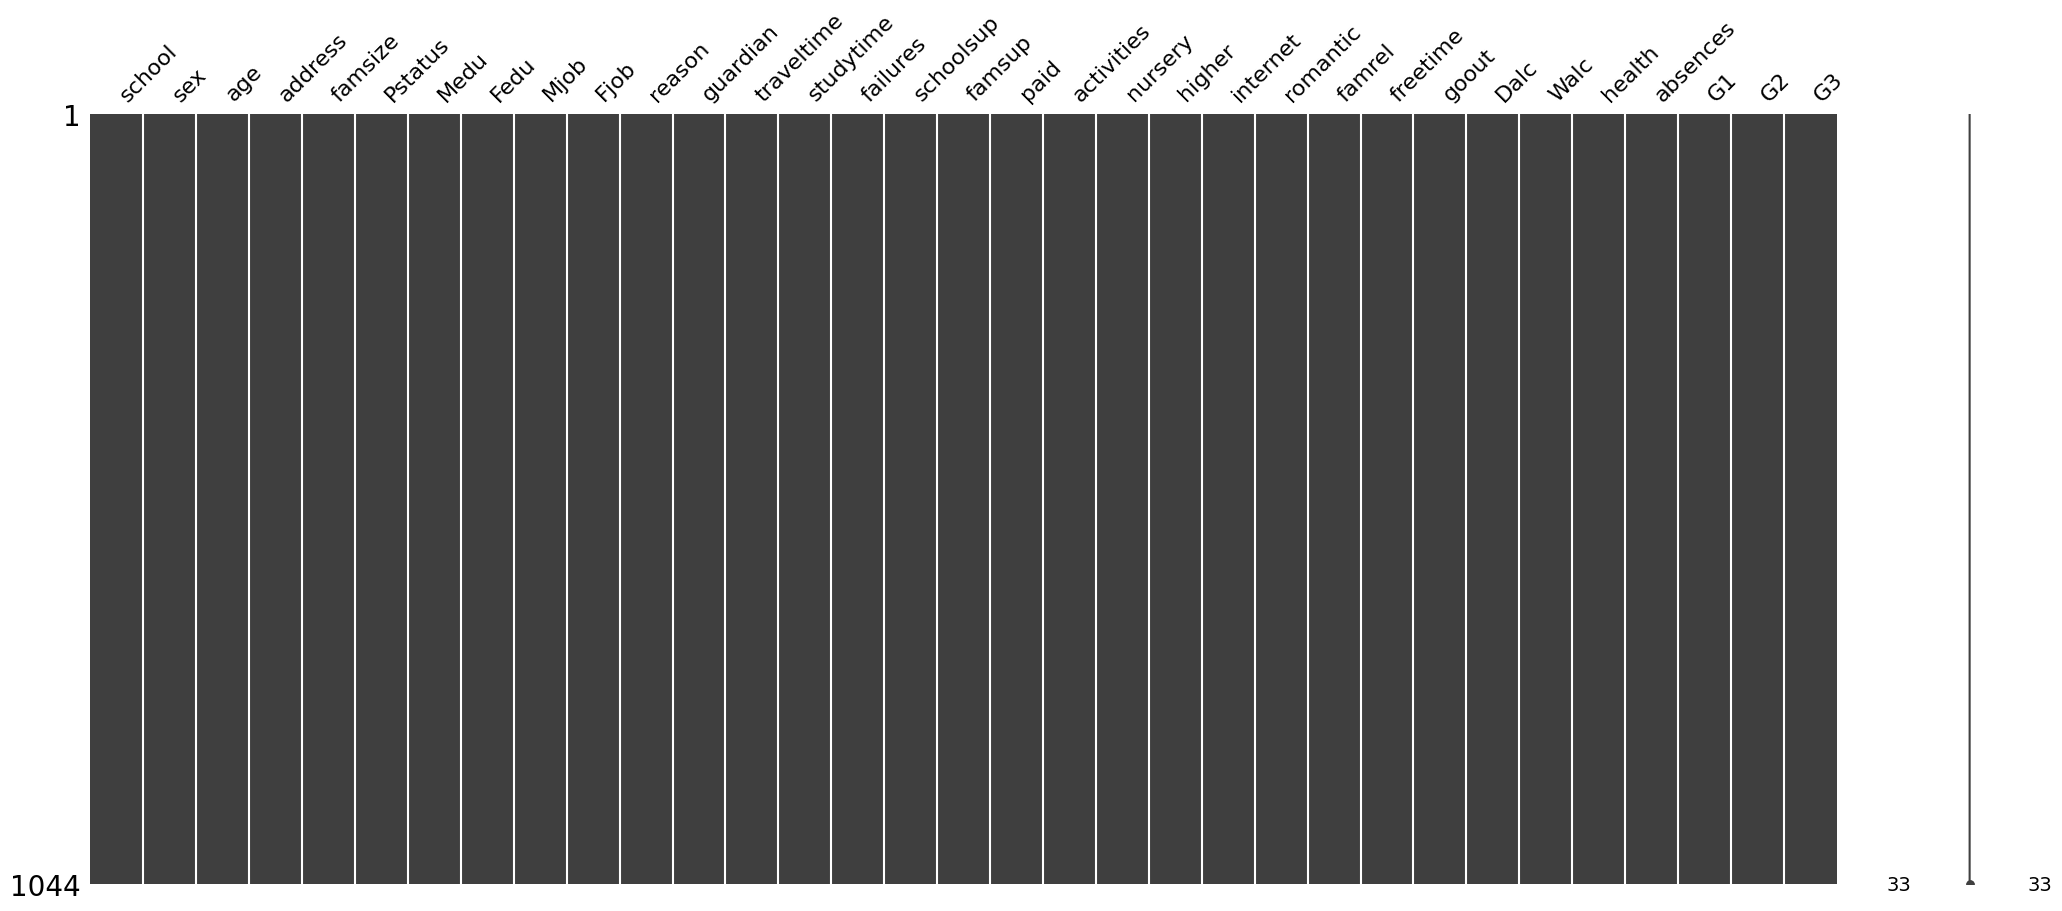

In [803]:
msno.matrix(dataset)
plt.show()

Després d'examinar el nostre dataset, podem confirmar que no hi ha valors nuls o faltants (Nans) presents en les dades. Tots els atributs del conjunt de dades estan complets, per la qual cosa no serà necessari realitzar cap tipus de tractament per gestionar aquests valors, com ara la imputació per mitjana, moda o altres tècniques de completació. Això ens permet treballar directament amb les dades disponibles sense la necessitat de dur a terme cap procés addicional de neteja o substitució de valors.

Ara es farà l'anàlisi de la relació entre els atributs d'entrada (X o features) i la variable objectiu (y o target). Per facilitar l'anàlisi, dividirem aquest estudi en dues parts:

**Atributs numèrics (numeriques i ordinals)**: Explorarem com les variables numèriques es relacionen amb la variable objectiu. Utilitzarem tècniques com la correlació (coeficient de Pearson) per identificar els possibles patrons entre aquestes variables.

Es mostren característiques abans de ser codificades, desprès de la codificació es tornarà a fer el mateix.

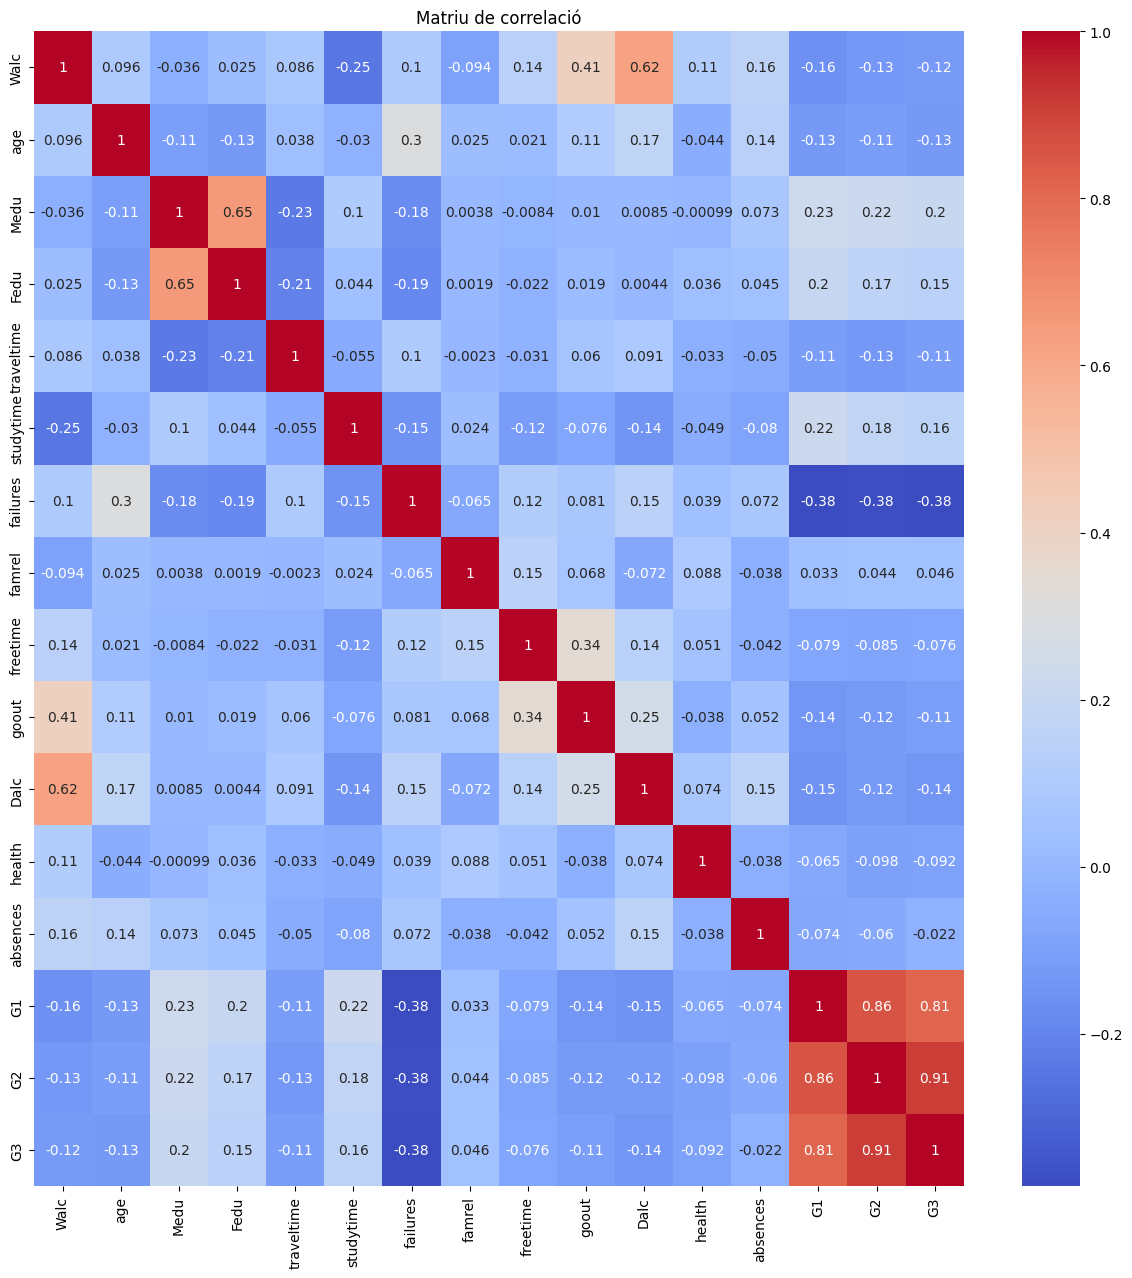

In [804]:
nume_features = ['Walc', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health', 'absences', 'G1', 'G2', 'G3']
corr_matrix = train[nume_features].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()

A continuació es descriuen les diferents correlacions entre els atributs numèrics i el target (consum d'alcohol durant el cap de setmana, Walc):

- **Dalc i Walc (0.62)**: La forta correlació positiva entre el consum d'alcohol durant els dies laborables (Dalc) i el consum durant el cap de setmana (Walc) indica que els estudiants que consumeixen alcohol durant la setmana també tendeixen a fer-ho durant els caps de setmana. Això suggereix patrons de consum més constants i un possible risc de consum habitual.

- **goout i Walc (0.41)**: Existeix una correlació positiva moderada entre la freqüència de sortides amb amics i el consum d'alcohol durant el cap de setmana. Aquest resultat és esperable, ja que sortir amb amics en contextos informals o festius sovint està associat amb un augment del consum d'alcohol.

- **studytime i Walc (-0.25)**: Es detecta una correlació negativa feble entre el temps d'estudi setmanal i el consum d'alcohol durant el cap de setmana. Aquesta relació, tot i que no és molt intuitiva, podria tenir sentit en el context de que els estudiants que consumeixen alcohol amb més freqüència els caps de setmana podrien dedicar menys temps a l'estudi, ja que poden prioritzar les activitats socials per sobre de les acadèmiques.

- **absences i Walc (0.16)**: La correlació positiva feble entre les absències escolars i el consum d'alcohol durant el cap de setmana podria indicar que els estudiants que consumixen alcohol en excés també tenen més probabilitats de faltar a classe, especialment després de caps de setmana amb molta festa.

- **freetime i Walc (0.14)**: La relació positiva feble suggereix que més temps lliure podria traduir-se en més oportunitats per consumir alcohol, especialment durant els caps de setmana, quan els estudiants tenen més temps per dedicar a activitats socials.

- **health i Walc (0.11)**: La correlació positiva feble entre la salut percebuda pels estudiants i el consum d'alcohol durant el cap de setmana podria indicar que els estudiants amb millor salut podrien estar més disposats a consumir alcohol durant els seus temps lliures, ja que no perceben efectes negatius immediats sobre la seva salut. Aquesta relació pot suggerir que aquells amb millor salut se senten més capacitats per participar en activitats socials, com sortir i consumir alcohol, sense percebre un impacte significatiu en el seu benestar.

- **famrel i Walc (-0.11)**: La correlació negativa feble entre la qualitat de les relacions familiars i el consum d'alcohol durant el cap de setmana indica que els estudiants amb un entorn familiar més fort i amb més suport emocional tendeixen a consumir menys alcohol, ja que reben més acompanyament i supervisió.

- **failures i Walc (0.1)**: Existeix una correlació positiva molt feble entre el nombre de suspensos i el consum d'alcohol durant el cap de setmana. Això pot indicar que el consum freqüent d'alcohol podria afectar negativament el rendiment acadèmic, ja sigui per la reducció del temps d'estudi o per una menor capacitat de concentració.

- **age i Walc (0.096)**: Tot i que la correlació és molt feble, s'observa una relació positiva entre l'edat i el consum d'alcohol durant els caps de setmana. Aquesta relació és coherent amb la tendència dels estudiants més grans a tenir més llibertat i oportunitats per sortir i experimentar amb l'alcohol. **Posible característica a descartar**.

- **traveltime i Walc (0.086)**: La correlació positiva bastant feble suggereix que els estudiants amb desplaçaments més llargs podrien tenir un estil de vida més independent, el que podria portar a un augment en el consum d'alcohol durant els caps de setmana. **Posible característica a descartar**.

- **G1, G2, G3 i Walc (-0.12, -0.13, -0.16)**: La correlació negativa entre les qualificacions acadèmiques (notes G1, G2 i G3) i el consum d'alcohol durant els caps de setmana suggereix que els estudiants que consumeixen més alcohol tendeixen a obtenir pitjors resultats acadèmics. Això podria ser causat per la disminució del temps d'estudi, la fatiga o la dificultat per concentrar-se a causa del consum excessiu d'alcohol.

Entre altres que no s'han considerat per la seva correlacio molt baixa, com per exemple **Medu i Fedu**.

Les correlacions esmentades anteriorment són orientatives, però no afirmen de manera rotunda que la relació sigui exactament com es descriu. El coeficient de correlació és més significatiu per a característiques quantitatives, com les notes G1, G2, G3 o el nombre d'absències. El que vull dir és que, tot i que es poden presentar característiques nominals en format ordinal, aquestes poden ser malinterpretades i portar a errors en la interpretació de les correlacions.

La idea principal aquí es aclarir que, tot i que les correlacions poden ser útils, cal tenir en compte que algunes característiques, especialment les nominals o ordinals, poden ser interpretades incorrectament i donar lloc a conclusions errònies

**Atributs categòrics**: Analitzarem la relació entre les variables categòriques i la variable objectiu, utilitzant gràfics per observar com la distribució de les diferents categories influeix en la predicció. El següent gràfic mostra la taxa de consum d'alcohol al caps de setmana en funció variables categòriques: school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic.

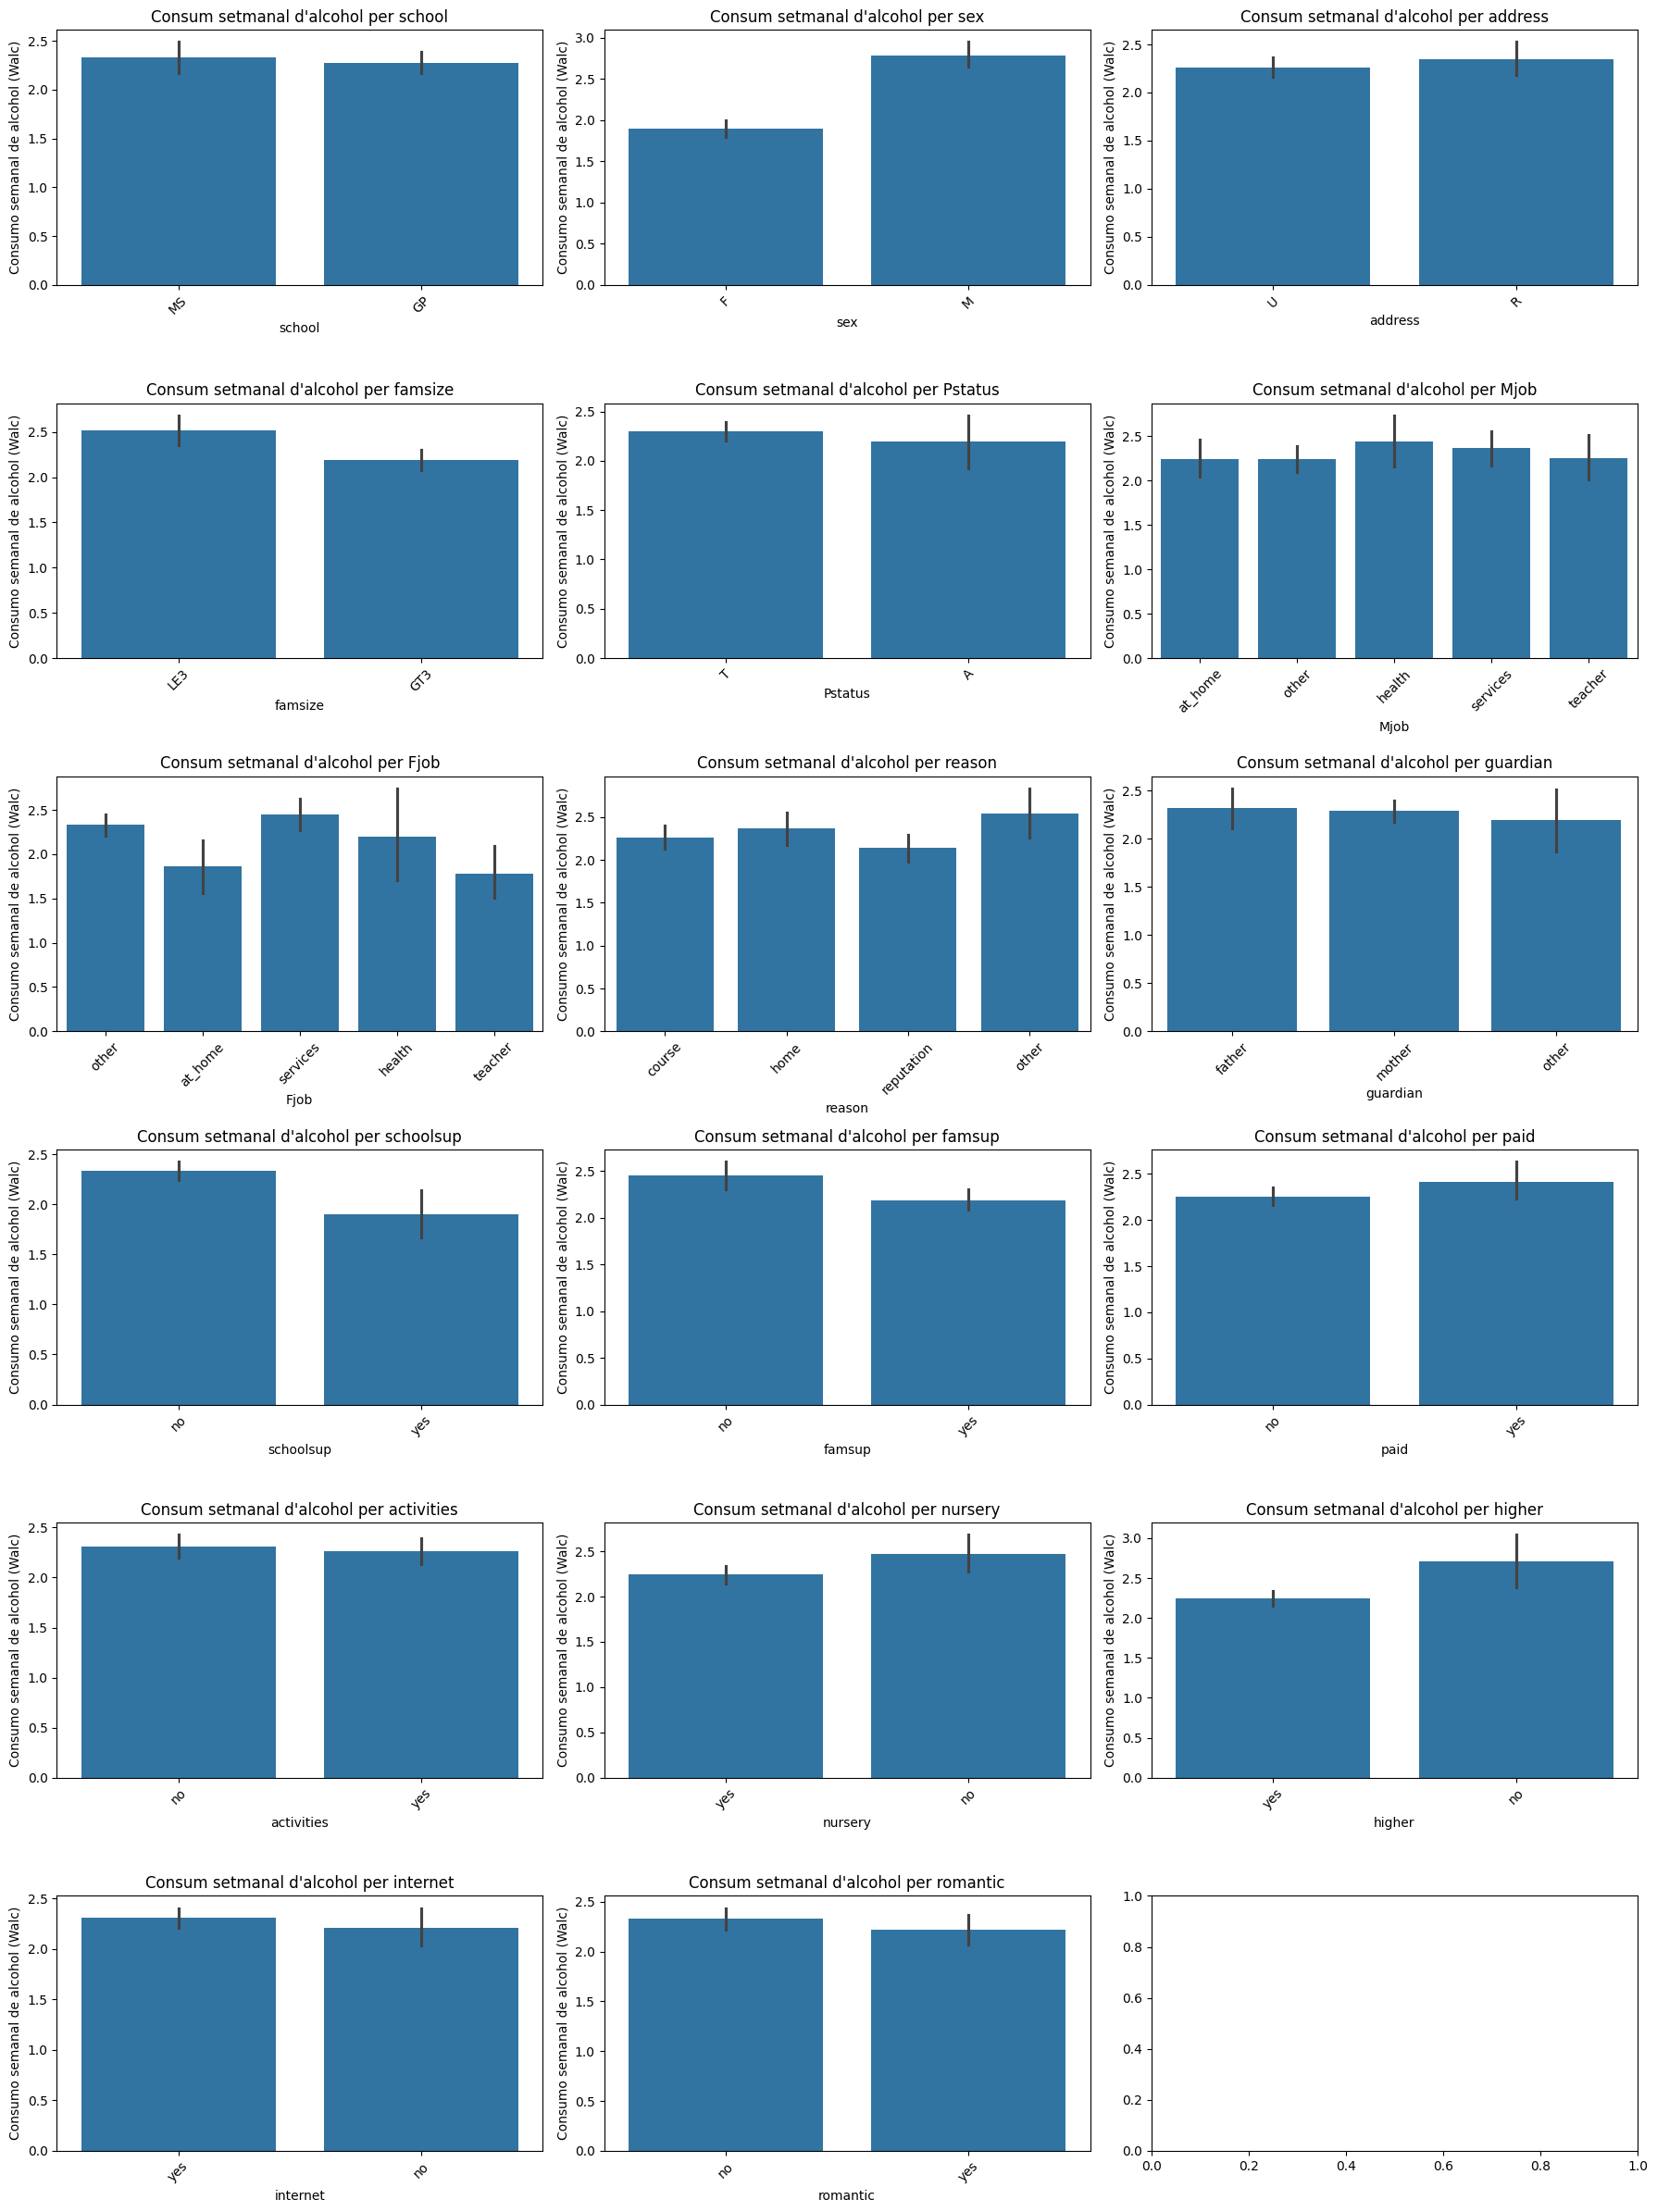

In [805]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables categóricas
categ_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
              'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
              'famsup', 'paid', 'activities', 'nursery', 'higher', 
              'internet', 'romantic']

# Crear los subgráficos
fig, axes = plt.subplots(6, 3, figsize=(18, 24))  # Ajusta el tamaño de la figura si es necesario

# Iterar a través de las variables categóricas
for idx, var in enumerate(categ_vars):
    row, col = divmod(idx, 3)  # Ubicación de cada gráfico
    # Graficar el consumo semanal de alcohol ('Walc') en función de la variable categórica
    sns.barplot(x=var, y='Walc', data=train, ax=axes[row, col])
    axes[row, col].set_title(f'Consum setmanal d\'alcohol per {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Consumo semanal de alcohol (Walc)')
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje x


# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


- Pel cas de l'atribut **sex**, es destaca que els estudiants masculins (M) mostren un consum d'alcohol més elevat en comparació amb les estudiants femenines (F). Aquesta diferència podria estar relacionada amb factors socials o culturals que influeixen en el comportament dels estudiants durant el cap de setmana.

- Pel cas de l'atribut **famsize**, els estudiants amb famílies més petites (LE3, menys o igual a 3 membres) presenten un consum lleugerament superior en comparació amb els de famílies més grans (GT3). Això podria suggerir que els estudiants de famílies petites tenen més llibertat o menys supervisió familiar.

- Pel cas de l'atribut **Fjob**, destaca la categoria de services com la que té un consum setmanal d'alcohol més alt. Això podria indicar que els estudiants amb pares que treballen en serveis estan més exposats a situacions que fomenten el consum d'alcohol, o que l'entorn familiar i socioeconòmic influeix en aquest comportament.

- Pel cas de l'atribut **schoolsup**, aquells estudiants que no reben suport educatiu addicional (no) tendeixen a mostrar un consum més elevat d'alcohol durant el cap de setmana. Aquesta observació pot indicar que els estudiants que necessiten menys suport podrien tenir més temps lliure o menys pressió acadèmica.

- Pel cas de l'atribut **famsup**, els estudiants que no reben suport educatiu de la família (no) presenten un consum lleugerament superior en comparació amb aquells que sí el reben. Això pot reflectir un menor control parental o un entorn familiar menys estructurat.

- Pel cas de l'atribut **nursery**, destaca lleugerament la categoria de no. Els estudiants que no van assistir a l'escola bressol mostren un consum d'alcohol una mica més alt, tot i que la diferència no és molt pronunciada. Això podria estar vinculat a diferents tipus de socialització primerenca.

- Pel cas de l'atribut **higher**, destaca la categoria no amb un consum més elevat. Els estudiants que no tenen intenció de continuar amb estudis superiors tendeixen a consumir més alcohol, la qual cosa pot indicar una actitud més despreocupada cap al futur acadèmic o una menor motivació educativa.

Respecte a les altres que no s'han mencionat, degut a l'equilibri entre les classes dels atributs, no s'han considerat com per exemple; **address, guardian, activities, internet, romantic**, entre altres que es continuaran supervisant per un posible descart.
 
Ara que ja coneixem la importància de cada característica, procedirem a considerar què fer amb elles, com eliminar les més insignificants o realitzar algun tipus de càlcul conjunt per poder obtenir una nova característica amb més informació.

### 2. Preprocessing

Després d'analitzar el conjunt de dades, hem comprovat que no hi ha valors nuls (NaNs) en cap de les característiques del train. Això facilita considerablement la preparació de les dades. Per tant, podem saltar-nos el procés d'imputació o eliminació de dades mancants.

In [806]:
train_NaN_P = (train.isna().sum() / len(train)) * 100
train_NaN = pd.DataFrame({
    'Número': train.isna().sum(),
    'Percentatge': train_NaN_P
})
print("TRAIN_DATA - Valors nuls:")
print(train_NaN)

TRAIN_DATA - Valors nuls:
            Número  Percentatge
school           0          0.0
sex              0          0.0
age              0          0.0
address          0          0.0
famsize          0          0.0
Pstatus          0          0.0
Medu             0          0.0
Fedu             0          0.0
Mjob             0          0.0
Fjob             0          0.0
reason           0          0.0
guardian         0          0.0
traveltime       0          0.0
studytime        0          0.0
failures         0          0.0
schoolsup        0          0.0
famsup           0          0.0
paid             0          0.0
activities       0          0.0
nursery          0          0.0
higher           0          0.0
internet         0          0.0
romantic         0          0.0
famrel           0          0.0
freetime         0          0.0
goout            0          0.0
Dalc             0          0.0
Walc             0          0.0
health           0          0.0
absences      

Organitzem les caracterítiques i les allsitem per poder codificar-les segons convingui.

In [807]:
nominal_features = ['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 
                    'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                    'higher', 'internet', 'romantic']

ordinal_features = ['famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                    'famrel', 'freetime', 'goout', 'Dalc', 'health'] # Walc no es codifica

numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

Com haviem mencionar hi han característiques tant ordinàries com nominals que tenen nomès dos valors (binari) per tant poder codificarles com **ordinal binary** (1 o 0).

In [808]:
categorical_binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
                               'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                               'higher', 'internet', 'romantic']

categorical_nominal_features = ['Mjob', 'Fjob', 'reason', 'guardian']

categorical_ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                                'famrel', 'freetime', 'goout', 'Dalc', 'health'] #Walc no se codifica

categorical_numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

Abans de procedir amb l'anàlisi, es realitzarà un ràpid test de Chi-quadrat per avaluar la relació entre cada característica del dataset i la variable objectiu Walc i aixi confirmar si realment hem de elimiar aquelles caracteritiques mencionades. El criteri que seguirem per decidir si una característica és útil o no es basa en el valor 𝑝:

Si 𝑝<0.05, considerarem que la característica té una relació estadísticament significativa amb Walc. Aquestescaracterístiques seran candidates a mantenir en el model.

Si 𝑝≥0.05, considerarem que la característica no té una relació significativa amb Walc i podrà ser descartada del model, ja que no contribueix de manera rellevant a la predicció.

In [ ]:
temp_features = categorical_binary_features + categorical_nominal_features + categorical_ordinal_features

temp_train = train.copy()
label_encoders = {}

for feature in temp_features:
    le = LabelEncoder()
    temp_train[feature] = le.fit_transform(train[feature])
    label_encoders[feature] = le

results = []

for feature in temp_features:
    contingency_table = pd.crosstab(temp_train[feature], temp_train['Walc'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    results.append({'Feature': feature, 'Chi2': chi2, 'P-Value': p, 'DoF': dof})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='P-Value')

print(results_df)

       Feature        Chi2        P-Value  DoF
25        Dalc  552.089324  3.242386e-107   16
24       goout  204.522894   9.648015e-35   16
1          sex  101.815669   4.038697e-21    4
20   studytime   74.384019   4.803174e-11   12
23    freetime   77.795794   4.142846e-10   16
19  traveltime   62.197192   8.948990e-09   12
5    schoolsup   26.035214   3.113142e-05    4
14        Fjob   39.402931   9.510081e-04   16
22      famrel   31.156381   1.285064e-02   16
6       famsup   12.674314   1.298182e-02    4
10      higher   11.405592   2.236470e-02    4
3      famsize   10.692628   3.024454e-02    4
8   activities   10.384072   3.443189e-02    4
0       school   10.238896   3.659015e-02    4
21    failures   22.017036   3.732933e-02   12
18        Fedu   27.190372   3.941509e-02   16
17        Medu   24.112243   8.708149e-02   16
4      Pstatus    7.517770   1.109283e-01    4
15      reason   15.486309   2.159123e-01   12
12    romantic    4.676975   3.220754e-01    4
26      healt

Després d'aplicar el test de Chi-quadrat per avaluar la relació entre cada característica del nostre dataset i l'objectiu Walc, hem classificat les característiques en tres grups: molt útils, moderadament útils i candidates a eliminació, seguint un criteri de significació estadística (𝑝<0.05).

**Característiques molt útils**:

Dalc, goout, sex, studytime, freetime

**Característiques moderadament útils**:

traveltime, schoolsup, Fjob, famrel, famsup, higher, famsize, activitie, school, failures, Fedu

**Característiques candidates a eliminació**:

Medu, Pstatus, reason, romantic, health, nursery, address, internet, paid, guardian, Mjob

**Decisió**:
Les característiques menys significatives poden eliminar-se per reduir la complexitat del model, prioritzant les més rellevants com Dalc, goout i sex, per construir un model més eficient i interpretable.

Per a millorar la qualitat del model i evitar la influència de característiques que no aporten informació rellevant, he decidit eliminar les següents columnes. Algunes d'elles tenen una relació molt baixa amb les variables ordinals, mentre que d'altres presenten un gran balanç en les categories nominales, la qual cosa no afegeix valor al model.

Columns que es dropegen:

- **guardian**: Aquesta columna indica qui és el tutor de l'alumne. No aporta informació significativa en relació amb les variables ordinals com les notes, ja que no hi ha una relació clara entre qui sigui el tutor i el rendiment escolar.
- **school**: Com la majoria dels alumnes provenen de la mateixa escola, aquesta columna té un valor constant i no genera variabilitat, per tant, no ajuda a la predicció.
- **address**: La direcció de l'estudiant pot no ser tan rellevant per la predicció del rendiment acadèmic, especialment si no s'està modelant una variable geogràfica.
- **activities**: Les activitats extraescolars no sempre tenen una correlació clara amb el rendiment acadèmic, i la seva distribució entre categories podria estar molt equilibrada, fent que no aporti prou informació rellevant.
- **internet**: Tot i que l'accés a Internet podria ser important, aquesta columna té poques categories (per exemple, accés o no accés), i el seu balanç entre classes fa que no afegeixi molta informació al model.
- **romantic**: La relació romàntica de l'alumne també té una distribució equilibrada entre les categories i, per tant, no és una característica que pugui ser útil per preveure el rendiment acadèmic.
- **Pstatus**: L'estat de convivència dels pares (si viuen junts o no) és una columna que no aporta gaire informació, ja que, en general, la seva correlació amb el rendiment acadèmic és baixa.
- **paid**: Les classes pagades extra no generen molta variabilitat o relació amb les variables ordinals del rendiment escolar, així que la seva eliminació no afecta de manera negativa al model.
- **Medu' i Fedu**: Tot i que l'educació dels pares podria ser rellevant, ja que es tracta de variables ordinals, he decidit eliminar-les perquè tenen una correlació molt baixa amb la variable objectiu en aquest cas.
- **traveltime**: El temps de viatge fins a l'escola pot no ser una variable significativa, especialment si els valors són constants o gairebé constants per a tots els alumnes, sense aportar informació rellevant al model.

Aquesta 11 caracteristiques descartades tenen la finalitat de evitar l'addició de soroll al model i per reduir el nombre total de característiques, el qual podria generar overfitting. Quan aquestes columnes es codifiquen mitjançant tècniques com One-Hot Encoding, podrien augmentar considerablement el nombre de característiques del model, especialment si hi ha moltes categories en les variables nominals. Això podria resultar en un model massa complex, que es pugui ajustar massa bé als detalls específics de les dades d'entrenament, però que no generalitzi bé a dades noves.

Per eliminar les característiques que hem considerat poc útils, podem utilitzar el següent codi per "dropear" les columnes del dataset:

In [810]:
columns_to_drop = ['guardian', 'school', 'address', 'activities', 'internet', 
                    'romantic', 'Pstatus', 'paid', 'Medu', 'Fedu', 'traveltime']

train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)


Desprès d'eliminar les característiques quedaríen de la seguent manera:


In [811]:
categorical_binary_features = ['sex', 'famsize', 'schoolsup', 'famsup', 'nursery', 'higher']

categorical_nominal_features = ['Mjob', 'Fjob', 'reason']

categorical_ordinal_features = ['studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health'] # Walc no es codifica

categorical_numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

Descripció de la codificació de les característiques:

- **Atributs categòriques (binàries i nominales)**:
Les variables categòriques són aquelles que no tenen un ordre intrínsec, i es poden classificar en dos tipus: binàries i nominales.

- **Atributs binàries**: 
Aquestes variables només tenen dues categories possibles, per exemple: sex, famsize, schoolsup, famsup, nursery, higher. Per a aquestes variables utilitzem un LabelEncoder, ja que es poden codificar simplement assignant un valor numèric (0 o 1) a cada categoria.

- **Atributs nominals**: Són aquelles que tenen més de dues categories, com Mjob, Fjob, reason. Aquestes variables no tenen un ordre implícit entre les categories, per tant, la millor opció per codificar-les és el OneHotEncoder, que crea una columna binària per cada categoria possible.

- **Atributs ordinals**:
Les variables ordinals tenen un ordre implícit entre les seves categories. Exemple d'aquestes variables són studytime, failures, famrel, freetime, goout, Dalc, health. Aquestes variables s'han de codificar de manera que es mantingui l'ordre entre les categories. Per això, podem utilitzar el OrdinalEncoder, que assigna valors numèrics a les categories seguint el seu ordre implícit.

- **Atributs numèriques**:
Les variables numèriques, com age, absences, G1, G2, G3 no requereixen codificació, però depenent del model, podrien necessitar normalització o estandardització.

**Codificació binària**: Per a les variables binàries, utilitzem *OrdinalEncoder*, que assigna valors numèrics de 0 o 1. S'ajusta i transforma el conjunt d'entrenament i després es transforma el conjunt de prova amb el mateix encoder.

In [812]:
# ---------------------- Binary Encoding ----------------------
binary_encoder = OrdinalEncoder()

# Ajustar y transformar para el conjunto de entrenamiento
train[categorical_binary_features] = binary_encoder.fit_transform(train[categorical_binary_features])

# Transformar para el conjunto de prueba
test[categorical_binary_features] = binary_encoder.transform(test[categorical_binary_features])

**Codificació One-Hot**: Per a les variables nominals, utilitzem **OneHotEncoder** per crear noves columnes, una per cada categoria. L'encoder s'ajusta i transforma el conjunt d'entrenament, i després només es transforma el conjunt de prova.

In [813]:
# ---------------------- One-Hot Encoding ----------------------
one_hot_encoder = ce.OneHotEncoder(cols=categorical_nominal_features, use_cat_names=True)

# Codificación One-Hot para el conjunto de entrenamiento
train = one_hot_encoder.fit_transform(train)

# Codificación One-Hot para el conjunto de prueba (solo transformando)
test = one_hot_encoder.transform(test)

**Codificació ordinal**: Per a les variables ordinals, utilitzem **OrdinalEncoder**, que manté l'ordre intrínsec de les categories. L'encoder s'ajusta i transforma el conjunt d'entrenament, i després es transforma el conjunt de prova.

In [814]:
# ---------------------- Ordinal Encoding ----------------------
ordinal_encoder = OrdinalEncoder()

# Ajustar y transformar para el conjunto de entrenamiento
train[categorical_ordinal_features] = ordinal_encoder.fit_transform(train[categorical_ordinal_features])

# Transformar para el conjunto de prueba
test[categorical_ordinal_features] = ordinal_encoder.transform(test[categorical_ordinal_features])

train.head(10)

,sex,age,famsize,Mjob_at_home,Mjob_other,Mjob_health,Mjob_services,Mjob_teacher,Fjob_other,Fjob_at_home,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
984,0.0,17,1.0,1,0,0,0,0,1,0,...,4.0,4.0,0.0,0.0,1,2.0,0,7,10,10
118,1.0,17,0.0,0,1,0,0,0,1,0,...,4.0,1.0,3.0,0.0,4,4.0,20,9,7,8
687,0.0,17,0.0,0,1,0,0,0,1,0,...,3.0,2.0,3.0,0.0,3,4.0,2,11,12,14
372,0.0,17,0.0,0,1,0,0,0,0,1,...,2.0,3.0,2.0,0.0,1,2.0,8,13,11,11
583,0.0,16,1.0,0,1,0,0,0,1,0,...,3.0,3.0,4.0,0.0,1,3.0,0,14,14,15
463,0.0,15,1.0,0,0,1,0,0,0,0,...,3.0,0.0,2.0,0.0,3,3.0,0,11,10,11
975,1.0,19,0.0,0,1,0,0,0,1,0,...,3.0,3.0,3.0,2.0,3,4.0,4,8,9,10
514,1.0,15,0.0,0,1,0,0,0,1,0,...,2.0,3.0,2.0,0.0,2,3.0,2,14,13,14
727,0.0,18,0.0,1,0,0,0,0,0,1,...,3.0,2.0,2.0,0.0,2,1.0,0,18,18,18
784,0.0,18,1.0,0,1,0,0,0,1,0,...,3.0,2.0,2.0,0.0,1,1.0,0,10,9,12


Explicació de la normalització i per què s'ha escollit MinMaxScaler:

En primer lloc, hem aplicat una normalització a les variables numèriques utilitzant el MinMaxScaler. Aquesta tècnica transforma les variables numèriques perquè estiguin en un rang de [0, 1], mantenint la seva relació proporcional original. L'objectiu és assegurar-nos que totes les variables tinguin la mateixa escala, ja que alguns models d'aprenentatge treballan amb distàncies la qual facilita el calcul, com per exemple tenim a **SVM** i **KNN** que poden veure's afectats per les diferents escales de les variables.

Aquesta elecció de **MinMaxScaler** en particular es justifica perquè, en el nostre conjunt de dades, les variables numèriques com **age**, **absences**, **G1, G2 i  G3** poden tenir valors amb diferent rang (per exemple, **age** pot tenir valors entre 15 i 25, mentre que **G1, G2, G3** pot estar entre 0 i 20) o el nombre d'absència (0 a n). Al normalitzar-les, aconseguim que el model no es vegi influenciat per aquesta diferència de magnitud, ajudant-lo a convergir més ràpidament i a ser més precís en el seu aprenentatge.

Procés de normalització:
Ajustem el **MinMaxScaler** al conjunt d'entrenament (utilitzant fit), per tal d'obtenir el mínim i màxim de cada variable numèrica.

Transformem tant el conjunt d'entrenament com el de prova per aplicar aquesta normalització a les dades, mantenint la coherència entre ambdós conjunts.

In [815]:
# ---------------------- Normalització per MinMaxScaler ----------------------
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train[categorical_numerical_features])

train[categorical_numerical_features] = min_max_scaler.transform(train[categorical_numerical_features])
test[categorical_numerical_features] = min_max_scaler.transform(test[categorical_numerical_features])

# ---------------------- Guarden el preprocessing ----------------------

train.to_csv('PreprocessingDoneTrain.csv', index=False)
test.to_csv('PreprocessingDoneTest.csv', index=False)

train.head(10)

,sex,age,famsize,Mjob_at_home,Mjob_other,Mjob_health,Mjob_services,Mjob_teacher,Fjob_other,Fjob_at_home,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
984,0.0,0.285714,1.0,1,0,0,0,0,1,0,...,4.0,4.0,0.0,0.0,1,2.0,0.000000,0.200000,0.526316,0.50
118,1.0,0.285714,0.0,0,1,0,0,0,1,0,...,4.0,1.0,3.0,0.0,4,4.0,0.266667,0.333333,0.368421,0.40
687,0.0,0.285714,0.0,0,1,0,0,0,1,0,...,3.0,2.0,3.0,0.0,3,4.0,0.026667,0.466667,0.631579,0.70
372,0.0,0.285714,0.0,0,1,0,0,0,0,1,...,2.0,3.0,2.0,0.0,1,2.0,0.106667,0.600000,0.578947,0.55
583,0.0,0.142857,1.0,0,1,0,0,0,1,0,...,3.0,3.0,4.0,0.0,1,3.0,0.000000,0.666667,0.736842,0.75
463,0.0,0.000000,1.0,0,0,1,0,0,0,0,...,3.0,0.0,2.0,0.0,3,3.0,0.000000,0.466667,0.526316,0.55
975,1.0,0.571429,0.0,0,1,0,0,0,1,0,...,3.0,3.0,3.0,2.0,3,4.0,0.053333,0.266667,0.473684,0.50
514,1.0,0.000000,0.0,0,1,0,0,0,1,0,...,2.0,3.0,2.0,0.0,2,3.0,0.026667,0.666667,0.684211,0.70
727,0.0,0.428571,0.0,1,0,0,0,0,0,1,...,3.0,2.0,2.0,0.0,2,1.0,0.000000,0.933333,0.947368,0.90
784,0.0,0.428571,1.0,0,1,0,0,0,1,0,...,3.0,2.0,2.0,0.0,1,1.0,0.000000,0.400000,0.473684,0.60


Ara que hem realitzat el preprocessament de les dades i hem codificat les característiques nominals utilitzant tècniques com **One-Hot Encoding**, podem tornar a visualitzar la matriu de correlació per veure com han canviat les relacions entre les característiques numèriques després de tot el processament.

Les columnes que abans tenien valors nominales (com **'school', 'guardian', 'address'**, etc.) s'han convertit en noves columnes binàries a través de la codificació One-Hot, el que pot influir en la correlació de les característiques amb la variable objectiu i entre elles.

Per tant, la nova matriu de correlació ens proporcionarà una visió més clara de com les característiques processades, incloent les noves columnes creades per la codificació, estan relacionades entre elles. Aquesta visualització ens ajudarà a identificar possibles relacions importants, redundants o poc rellevants per al model que encara no han sigut identificades.

A continuació, podem generar la nova matriu de correlació per obtenir una comprensió més detallada de les interaccions entre les variables després de tot el preprocessament.

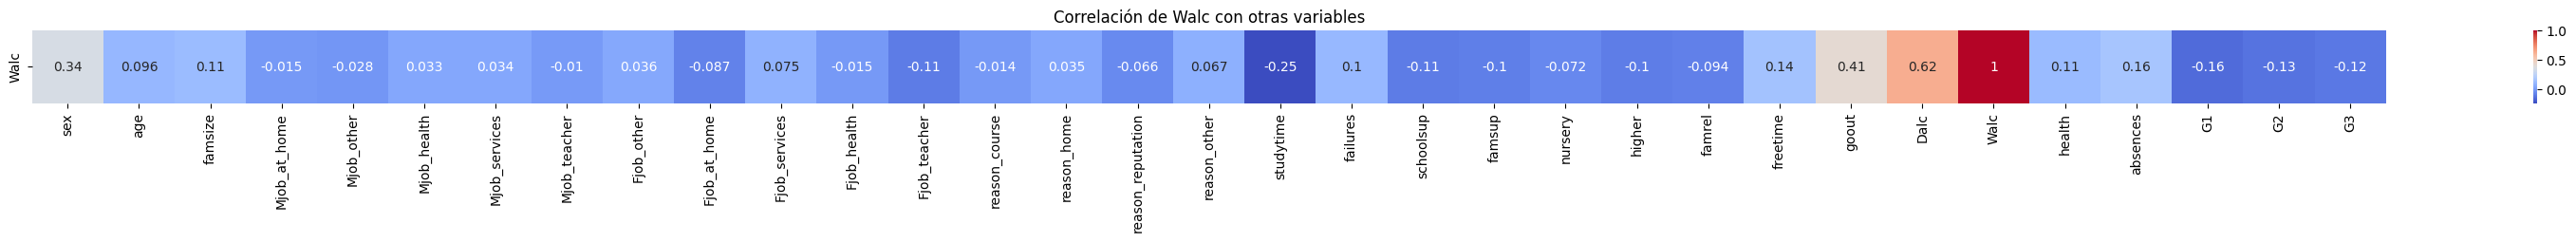

In [816]:
plt.figure(figsize=(40, 1)) 

corr_matrix = train.corr()
walc_corr = corr_matrix.loc['Walc'].to_frame().T
sns.heatmap(walc_corr, annot=True, cmap='coolwarm', cbar=True)

plt.title('Correlación de Walc con otras variables')
plt.show()

Ara que hem completat el preprocessament i la codificació de les característiques nominals, podem veure com algunes d'aquestes categories, com les de sex, famsize, Fjob, schoolsup, famsup, nursery i higher, ja es mostren amb més claredat. Aquesta era una observació esperada, ja que algunes d’aquestes categories havien destacat en el nostre anàlisi previ, tot i que no es van reflectir clarament en la matriu de correlació inicial. Això ens ajudarà a valorar la rellevància de les característiques a l’hora de construir el model.

### 3. Metric selection

Ara que ja tenim tots els atributs amb els quals entrenarem els models, l'objectiu és predir el nivell de consum d'alcohol durant els caps de setmana (Walc) dels estudiants. Per avaluar el rendiment dels models, utilitzarem mètriques que ens ajudin a obtenir una predicció precisa del comportament dels estudiants en relació al consum d'alcohol.

En aquest cas, el conjunt d'aprenentatge train està desbalancejat, ja que la distribució entre les diferents categories de Walc pot estar desequilibrada (per exemple, més estudiants amb un consum baix de begudes alcohòliques en comparació amb aquells amb un consum alt). Així, l'objectiu serà predir correctament tant els estudiants amb un consum baix com els que presenten un consum més elevat.

Per aquest tipus d'anàlisi, l'accuracy no serà suficient, ja que no reflectiria adequadament les diferències entre les categories. L'objectiu serà equilibrar la precisió i el recall, utilitzant la mètrica F1-score, que és ideal per a problemes amb classes desbalancejades. Aquesta mètrica és la mitjana harmònica entre la precisió i el recall, i ens permet aconseguir una mesura més equilibrada del rendiment del model.

Per a l'anàlisi principal, utilitzarem la matriu de confusió per examinar les diferents mètriques d'una predicció. A més, per entendre millor el comportament del model, també emprarem les corbes Precision-Recall (PR), ja que aquestes ens proporcionaran més informació sobre la precisió i el recall quan maximitzem la mètrica F1-score. Encara que la corba ROC també és útil per a models de classificació, en casos de classes desbalancejades, la corba PR és més informativa. Amb l'ajuda de l'AUC (Àrea sota la corba), podrem avaluar com de bé el model diferencia entre les classes.

Finalment, es farà servir una funció per analitzar el model utilitzant la corba PR.

In [817]:
'''
:param y_test: Etiquetes veritables (vector de classes reals)
:param y_pred_probs: Probabilitats predicte per a cada classe (matriu de mida [n_samples, n_classes])
:param n_classes: Nombre de classes en el problema multiclasse

'''
def plot_pr_curve_multiclass(y_test, y_pred_probs, n_classes):
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
        auc_score = auc(recall, precision)
        print(f'Clase {i} AUC: {auc_score:.3f}')
        
        plt.plot(recall, precision, marker='.', label=f'Clase {i} (AUC = {auc_score:.3f})')

    no_skill = len(y_test_bin[y_test == 1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin capacidad predictiva')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curvas PR por clase')
    plt.legend(loc='best')

    plt.show()


### 4. Model Selection amb validacio creuada

En aquest apartat ens centrarem en la selecció dels diferents models, aplicant diferents tècniques d'aprenentatge supervisat. La mètrica de rendiment per avaluar el model serà F1-score, raonada a l'apartat anterior. L'objectiu és poder identificar el millor model a través de fer proves de validació creuada, a més, amb aquesta prova identificarem els models que tendeixen a fer overfitting per tal d'evitar-lo. Com les dades estan desbalancejades quan fem la validació creuada, utilitzarem la funció 'StratifiedKFold' en la validació creuada per assegurar-nos que les particions mantinguin la proporció de cada classe en cada subdivisió.

Per la selecció de models el que hem fet ha sigut provar-ho amb 6 models diferents que són: Logistic Regression, SVC, K-Nearest Neighbors (KNN), DecisionTreeClassifier, Random Forest Classifier i AdaBoostClassifier. Cadascú té diferents tipus de tècniques de cara a fer la predicció, per això és bo comparar diferents enfocaments per veure quin model s'adapta millor al conjunt de dades.

Per escollir aquests models s'ha tingut en compte que hi ha models que són lineals (regressió logística) i no lineals (com SVC i altres) per així considerar diferents relacions entre les variables independents i la variable objectiu. A més, per abarcar més tipus, hi ha models que són sensibles a l'escala, com SVC i KNN, per aquest motiu abans s'ha normalitzat les dades amb l'objectiu de poder treballar millor amb aquests models.

També, per fer el model s'han considerat models més complexos, com el Random Forest i l'AdaBoost, per tal de veure com es comporta les dades davant aquests models que utilitzen diferents tècniques com Bagging i Boosting per tal de reduir l'error del model final, ja que s'entrenen diversos models per prendre una decisió conjunta. Així podrem veure quin s'adapta millor a les nostres dades i anirem a prendre una decisió per finalment avaluar el nostre model amb dades que mai ha vist anteriorment.

In [818]:
X = train.drop('Walc', axis=1)
y = train['Walc']
X_test = test.drop('Walc', axis=1)
y_test = test['Walc']

print("Informació de cada atribut:")
print(X.info())
print("El nombre de mostres que tenim al train és de", train.shape[0])
print("El nombre de atributs que tenim al train és de", train.shape[1])
print(X_test.info())
print("El nombre de mostres que tenim al test és de", test.shape[0])
print("El nombre de atributs que tenim al test és de", test.shape[1])

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
Index: 783 entries, 984 to 158
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                783 non-null    float64
 1   age                783 non-null    float64
 2   famsize            783 non-null    float64
 3   Mjob_at_home       783 non-null    int64  
 4   Mjob_other         783 non-null    int64  
 5   Mjob_health        783 non-null    int64  
 6   Mjob_services      783 non-null    int64  
 7   Mjob_teacher       783 non-null    int64  
 8   Fjob_other         783 non-null    int64  
 9   Fjob_at_home       783 non-null    int64  
 10  Fjob_services      783 non-null    int64  
 11  Fjob_health        783 non-null    int64  
 12  Fjob_teacher       783 non-null    int64  
 13  reason_course      783 non-null    int64  
 14  reason_home        783 non-null    int64  
 15  reason_reputation  783 non-null    int64  
 16  r

He utilitzat la generació sintètica de mostres per equilibrar les classes al conjunt d'entrenament. Per això, vaig fer servir l'algoritme SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous), que és adequat per treballar amb característiques tant numèriques com categòriques. He considerat que les característiques nominales no han de ser alterades de manera significativa, per la qual cosa vaig definir els índexs de les característiques categòriques que poden ser ordinals o nominals. Aquestes són les que el SMOTENC pot gestionar sense problemes, i vaig especificar els següents índexs:

sex, Mjob_at_home, Mjob_other, Mjob_health, Mjob_services, Mjob_teacher, Fjob_other, Fjob_at_home, Fjob_services, Fjob_health, Fjob_teacher, reason_course, reason_home, reason_reputation, reason_other, studytime, failures, schoolsup, famsup, nursery, higher, famrel, freetime, goout, Dalc, health

He decidit generar el doble de mostres, però mantenint la distribució lleugerament perquè les classes de la variable Walc ara estiguin molt més equilibrades. L'estratègia de mostreig que vaig utilitzar va ser la següent:

In [819]:
categorical_features = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]

He decidit generar el doble de mostres, però mantenint la distribució lleugerament perquè les classes de la variable Walc ara estiguin molt més equilibrades. L'estratègia de mostreig que vaig utilitzar va ser la següent:

In [820]:
sampling_strategy = {1: 440, 2: 430, 3: 420, 4: 410, 5: 400}

In [821]:
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42, sampling_strategy=sampling_strategy)

X, y = smote_nc.fit_resample(X, y)

X.to_csv('PreprocessingDoneTrain.csv', index=False)
y.to_frame().to_csv('PreprocessingDoneTest.csv', index=False)  # Corregido para guardar y


Ara es farà el recompte de les classes al nou conjunt d'entrenament després d'aplicar la generació sintètica de mostres. Això ens permetrà verificar que les classes estan equilibrades correctament després de l'aplicació de SMOTENC. Podem fer aquest recompte utilitzant el mètode value_counts() sobre la variable y, que conté les etiquetes de classe.

Així, el codi per fer el recompte de les classes seria:

Walc
1    440
2    430
3    420
4    410
5    400
Name: count, dtype: int64


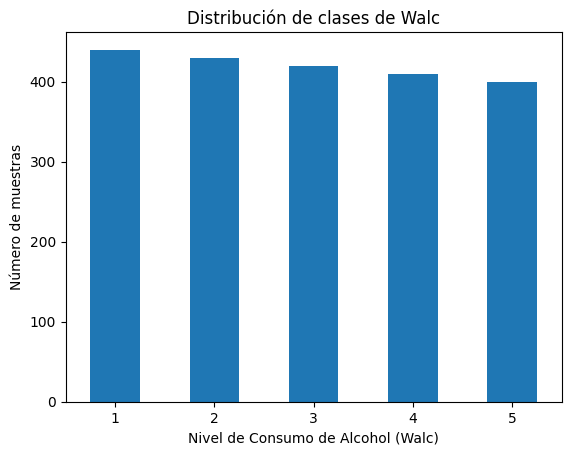

In [822]:
counts = y.value_counts()
print(counts)
counts.plot(kind='bar')
plt.title('Distribución de clases de Walc')
plt.xlabel('Nivel de Consumo de Alcohol (Walc)')
plt.ylabel('Número de muestras')
plt.xticks(rotation=0)
plt.show()

Ara farem el cross-validation sense paràmetres per veure com funciona cada model amb la mètrica que volem maximitzar.

In [823]:
# CROSS-VALIDATION DE LOGISTIC REGRESSION
model = LogisticRegression(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
lg_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("LogisticRegression:")
print(f"Scores en cada fold: {lg_scores}")
print(f"Media del score: {lg_scores.mean()}")

# CROSS-VALIDATION DE SUPER VECTOR CLASSIFIER
model = SVC(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
svc_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nSVC:")
print(f"Scores en cada fold: {svc_scores}")
print(f"Media del score: {svc_scores.mean()}")

# CROSS-VALIDATION DE KNN
model = KNeighborsClassifier()
stratified_kfold = StratifiedKFold()
knn_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nKNeighborsClassifier:")
print(f"Scores en cada fold: {knn_scores}")
print(f"Media del score: {knn_scores.mean()}")

# CROSS-VALIDATION DE DECISION TREE CLASSIFIER
model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
dt_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nDecisionTreeClassifier:")
print(f"Scores en cada fold: {dt_scores}")
print(f"Media del score: {dt_scores.mean()}")

# CROSS-VALIDATION DE RANDOM FOREST CLASSIFIER
model = RandomForestClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
rf_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nRandomForestClassifier:")
print(f"Scores en cada fold: {rf_scores}")
print(f"Media del score: {rf_scores.mean()}")

# CROSS-VALIDATION DE ADA BOOST CLASSIFIER AMB DECISION TREE CLASSIFIER
model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0), random_state=0)
stratified_kfold = StratifiedKFold()
ab_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nAdaBoostClassifier:")
print(f"Scores en cada fold: {ab_scores}")
print(f"Media del score: {ab_scores.mean()}")

KeyboardInterrupt: 

Visualitzem els resultats de cross-validation en una gràfica per veure millor la diferència entre cada model.

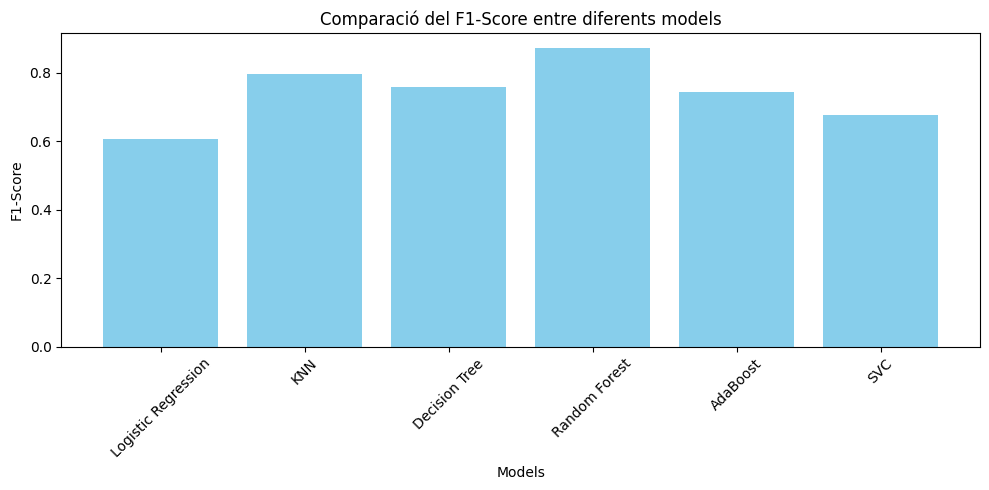

In [ ]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'SVC']
f1_means = [lg_scores.mean(), knn_scores.mean(), dt_scores.mean(), rf_scores.mean(), ab_scores.mean(), svc_scores.mean()]

plt.figure(figsize=(10, 5))
plt.bar(models, f1_means, color='skyblue')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Comparació del F1-Score entre diferents models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Amb aquesta gràfica podem veure que els millors models són el RandomForestClassifier i el KNeighborsClassifier, amb una mitjana de score de 0.873 i 0.796 respectivament. Aquests models han obtingut uns resultats molt bons en la seva validació creuada, amb scores que superen el 75% en totes les seves iteracions. Per altra banda, el DecisionTreeClassifier també ha mostrat un bon rendiment, amb una mitjana de score de 0.758, tot i que una mica per sota dels models de Random Forest i KNN.

El SVC i el LogisticRegression, tot i obtenir scores respectables (0.676 i 0.606 de mitjana respectivament), no han arribat al nivell de rendiment dels models més complexos. Això és una indicació que, per aquest conjunt de dades i aquest problema específic, els models més simples poden no ser tan eficients com els més poderosos com Random Forest o KNN. A pesar d'això, aquests resultats encara poden ser útils per obtenir una base sòlida per a comparacions futures.

En general, veiem que models com RandomForestClassifier i KNeighborsClassifier tenen un millor rendiment per a la classificació multiclasse en aquest conjunt de dades, especialment tenint en compte el desajustament inicial de les classes, que ha estat corregit gràcies a l'ús de SMOTENC. Els altres models, tot i que ofereixen bons resultats, no igualen el nivell de rendiment d'aquests dos últims.

Amb l'objectiu de treure el màxim profit de cada model, continuarem treballant en la millora de la mètrica F1-score, per tal d'optimitzar encara més la capacitat de predicció dels nostres models. Per fer-ho, utilitzarem Grid Search per a ajustar els hiperparàmetres i explorar totes les combinacions possibles de paràmetres per a trobar la configuració òptima per a cada model.

Els hiperparàmetres que es provaran durant el procés de Grid Search són els següents:

- **Logistic Regression**:
  - C: Controla la funció de cost. Quan el valor és petit, la regularització és forta i el model tendeix a ser més simple. En canvi, si el valor és gran, la regularització és dèbil, cosa que tendeix a generar un model més complex i, per tant, més propens al overfitting. 
  - max_iter: Nombre màxim d'iteracions per a l'optimització. Mentre més gran sigui aquest valor, més temps pot trigar el model a convergir. Si el valor és massa petit, el model pot no aconseguir una solució òptima.

- **Support Vector Classifier (SVC)**:
  - kernel: Tipus de nucli utilitzat per al SVM. 
  - gamma: Coeficient que determina la influència d'un sol exemple de formació. 

- **K-Nearest Neighbors (KNN)**:
  - weights: Defineix com es pesen els veïns. Si el valor és **uniform** el pes de les distàncies cap als veïns no vària, en canvi, si el valor és **distance** es dona més importància els veïns propers.
  - metric: Mètriques per a calcular les distàncies. En aquest cas, dues conegudes, la distància Euclidiana i la de Manhattan.

- **Decision Tree Classifier**:
  - criterion: Funció utilitzada per mesurar la qualitat de la divisió de les classes.

- **AdaBoost Classifier**:
  - n_estimators: Nombre d'arbres en el bosc.

In [ ]:
# GRID SEARCH DE LOGISTIC REGRESSION
print(f'LOGISTIC REGRESSION')
param_grid_lr = dict(
    C=[0.01, 0.1, 1, 10],  # Rango más moderado
    solver=['lbfgs', 'liblinear'],  # 'saga' solo es útil con datasets muy grandes o regulares
    max_iter=[100, 200, 300],
    tol=[1e-4]
)

lr_model = LogisticRegression(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_lr.fit(X, y)
lr_scores = grid_lr.best_score_
print(f'Millors parametres: {grid_lr.best_params_}')
print(f'Millor F1: {round(grid_lr.best_score_, 5)}')

# GRID SEARCH DE KNN
print(f'KNN')
param_grid_knn = dict(
    n_neighbors=[3, 5, 7, 9],  # Limitar vecinos para evitar modelos extremos
    weights=['uniform', 'distance'],
    metric=['euclidean', 'manhattan']
)

knn_model = KNeighborsClassifier()
stratified_kfold = StratifiedKFold()
grid_knn = GridSearchCV(knn_model, param_grid_knn, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_knn.fit(X, y)
knn_scores = grid_knn.best_score_
print(f'Millors parametres: {grid_knn.best_params_}')
print(f'Millor F1: {round(grid_knn.best_score_, 5)}')

# GRID SEARCH DE DECISION TREE CLASSIFIER
print(f'DECISION TREE CLASSIFIER')
param_grid_dt = dict(
    max_depth=[2, 4, 6],  # Profundidad limitada para evitar sobreajuste
    criterion=['gini', 'entropy'],
    min_samples_split=[2, 5, 10]  # Controlar cuándo dividir nodos
)

dt_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_dt = GridSearchCV(dt_model, param_grid_dt, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_dt.fit(X, y)
dt_scores = grid_dt.best_score_
print(f'Millors parametres: {grid_dt.best_params_}')
print(f'Millor F1: {round(grid_dt.best_score_, 5)}')

# GRID SEARCH DE RANDOM FOREST CLASSIFIER
print(f'RANDOM FOREST CLASSIFIER')
param_grid_rf = dict(
    n_estimators=[50, 100, 150],  # Ampliar número de árboles
    max_depth=[2, 4, 6],
    min_samples_split=[2, 5]  # Requerir más ejemplos por división
)

rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_rf.fit(X, y)
rf_scores = grid_rf.best_score_
print(f'Millors parametres: {grid_rf.best_params_}')
print(f'Millor F1: {round(grid_rf.best_score_, 5)}')

# CROSS-VALIDATION DE ADA BOOST CLASSIFIER AMB DECISION TREE CLASSIFIER
print(f'ADA BOOST CLASSIFIER')
param_grid_ab = dict(
    n_estimators=[50, 75, 100],  # Número razonable de estimadores
    learning_rate=[0.01, 0.1]  # Evitar valores altos que pueden causar inestabilidad
)

ab_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=0), algorithm='SAMME', random_state=0)
stratified_kfold = StratifiedKFold()
grid_ab = GridSearchCV(estimator=ab_model, param_grid=param_grid_ab, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_ab.fit(X, y)
ab_scores = grid_ab.best_score_
print(f'Millors parametres: {grid_ab.best_params_}')
print(f'Millor F1: {round(grid_ab.best_score_, 5)}')

# GRID SEARCH DE SUPER VECTOR CLASSIFIER
print(f'SUPER VECTOR CLASSIFIER')
param_grid_svc = dict(
    C=[0.1, 1, 10],  # Rango moderado para evitar modelos rígidos
    kernel=['linear', 'rbf'],  # Polinomios suelen ser más propensos al sobreajuste
    gamma=['scale'],
)

svc_model = SVC(probability=True, random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_svc = GridSearchCV(svc_model, param_grid_svc, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_svc.fit(X, y)
svc_scores = grid_svc.best_score_
print(f'Millors parametres: {grid_svc.best_params_}')
print(f'Millor F1: {round(grid_svc.best_score_, 5)}')


LOGISTIC REGRESSION


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Millors parametres: {'C': 10, 'max_iter': 200, 'solver': 'lbfgs', 'tol': 0.0001}
Millor F1: 0.61114
KNN
Millors parametres: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Millor F1: 0.86814
DECISION TREE CLASSIFIER
Millors parametres: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}
Millor F1: 0.64369
RANDOM FOREST CLASSIFIER
Millors parametres: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 150}
Millor F1: 0.75239
ADA BOOST CLASSIFIER
Millors parametres: {'learning_rate': 0.1, 'n_estimators': 100}
Millor F1: 0.80928
SUPER VECTOR CLASSIFIER
Millors parametres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Millor F1: 0.77751


En la gràfica següent podem visualitzar el valor òptim de la mètrica f1_macro per model amb multiclasse i tambe el parametre class_weight amb valor 'balanced' per mijorar l'entrenament amb train desbalancejat. Per a cada model al buscar els millors valors pels hiperparàmetres.

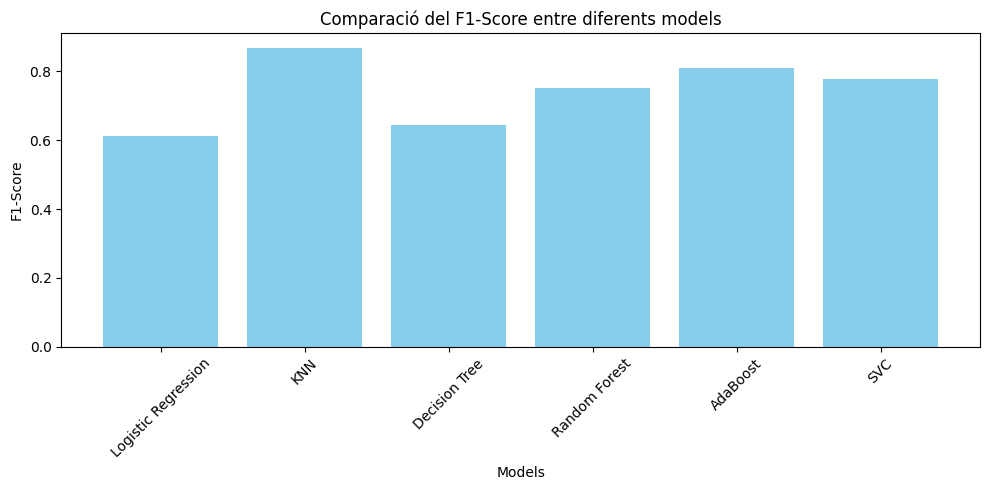

In [ ]:
# Modelos y sus F1-scores
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'SVC']
f1_score = [lr_scores, knn_scores, dt_scores, rf_scores, ab_scores , svc_scores]

# Crear gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(models, f1_score, color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Comparació del F1-Score entre diferents models')

# Ajustar el diseño
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Entre els models avaluats, els millors resultats es van obtenir amb el RandomForestClassifier, que va aconseguir una mitjana de score de 87.3%, destacant-se com el millor model per a la tasca de classificació multiclasse. Aquest model, amb diversos arbres de decisió, va mostrar un bon equilibri entre la precisió i el recall, especialment amb les classes més petites, beneficiant-se del tractament de les dades amb SMOTENC.

El KNeighborsClassifier també va obtenir uns resultats destacables amb un 79.7% de mitjana, mostrant-se com un model robust per a la classificació, tot i que una mica inferior al Random Forest. Els valors obtinguts van ser consistents en diversos folds, reflectint una bona capacitat de generalització. En aquest cas, el KNN utilitza la distància entre els punts per a classificar, i aquest comportament va ser eficient per a aquest conjunt de dades.

D’altra banda, el DecisionTreeClassifier va mostrar una mitjana de 75.8%. Tot i que aquest model no va arribar als nivells del Random Forest o el KNN, va seguir oferint una bona classificació, amb la capacitat de manejar bé les dades desbalancejades a causa de la seva estructura jeràrquica. Aquest model va ser útil per entendre la distribució de les classes i la manera en què les variables influïen en la predicció.

El SVC va obtenir una mitjana de 67.7%, destacant-se pel seu rendiment acceptable, però per sota dels altres models. Tot i així, el SVC és un model potent per a problemes de classificació amb marges ben definits, i en aquest cas va oferir resultats competitius, tot i que no els millors.

Finalment, la LogisticRegression va aconseguir un 60.6% de mitjana, quedant-se amb el resultat més baix. La regressió logística, tot i ser un model simple i ràpid d’entrenar, no va ser tan eficaç en aquest conjunt de dades amb múltiples classes, especialment després del balanceig de les mateixes.

Per tal de decidir el millor model, utilitzarem la corba d'aprenentatge per veure com evoluciona el rendiment de cada model quan s'augmenta la quantitat de dades d’entrenament. Aquesta anàlisi ens ajudarà a identificar quin model generalitza millor i és més estable per a futurs entrenaments, especialment en situacions de desbalanceig de les classes. A continuació, es farà una anàlisi més detallada dels resultats obtinguts.

A continuació, per visualitzar millor aquests resultats, presentarem les corbes d'aprenentatge per a cada model, que ens ajudaran a comprendre millor el seu comportament respecte a la generalització i l'overfitting a mesura que s'augmenten les dades d’entrenament.


Model: Logistic Regression
Diferencia final entre entrenamiento y validación: 0.0395
Puntuación final de validación: 0.6111

Model: KNN
Diferencia final entre entrenamiento y validación: 0.1319
Puntuación final de validación: 0.8681

Model: Decision Tree
Diferencia final entre entrenamiento y validación: 0.0545
Puntuación final de validación: 0.6437

Model: Random Forest
Diferencia final entre entrenamiento y validación: 0.1029
Puntuación final de validación: 0.7524

Model: AdaBoost
Diferencia final entre entrenamiento y validación: 0.1641
Puntuación final de validación: 0.8093

Model: SVC
Diferencia final entre entrenamiento y validación: 0.1159
Puntuación final de validación: 0.7775


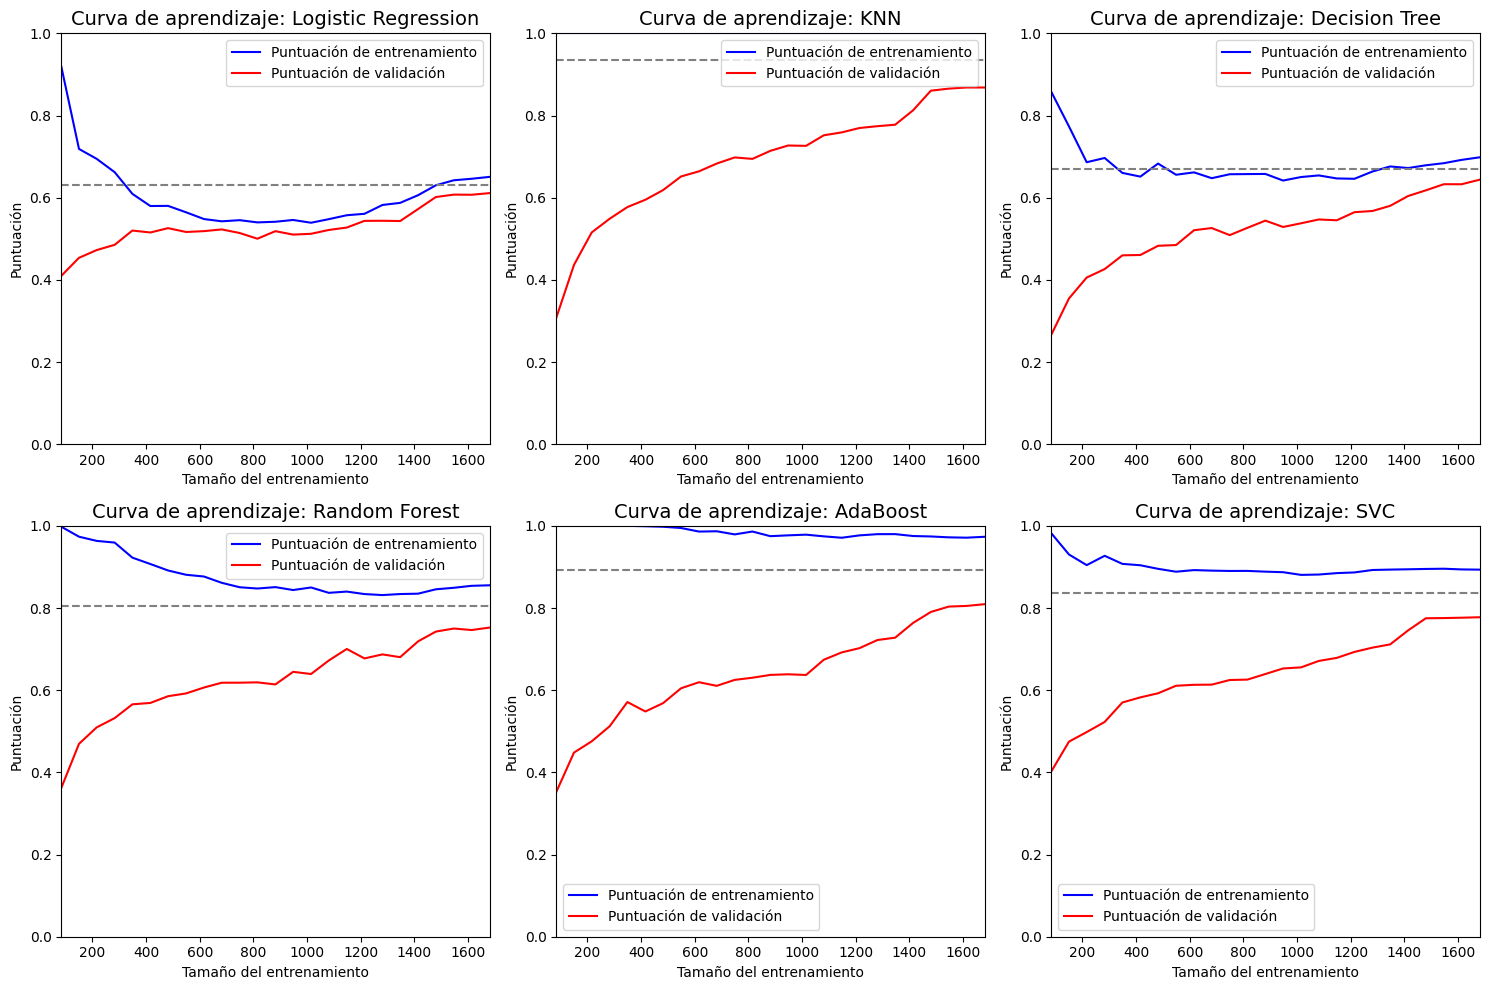

In [ ]:
def evaluate_and_plot_learning_curves(models, model_names, X, y):
    # Configura la figura con 2 filas y 3 columnas
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()  # Aplana la matriz de ejes

    stratified_kfold = StratifiedKFold()

    for idx, model in enumerate(models):
        name = model_names[idx]
        print(f"\nModel: {name}")
        
        # Calcular la curva de aprendizaje
        N, train_lc, val_lc = learning_curve(
            model, X, y, cv=stratified_kfold,
            train_sizes=np.linspace(0.05, 1, 25),
            n_jobs=-1,
            scoring='f1_macro'
        )
        
        # Promedios de las puntuaciones de entrenamiento y validación
        mean_train_score = np.mean(train_lc, axis=1)
        mean_val_score = np.mean(val_lc, axis=1)
        
        # Graficar la curva de entrenamiento
        axs[idx].plot(N, mean_train_score, color='blue', label='Puntuación de entrenamiento')
        
        # Graficar la curva de validación
        axs[idx].plot(N, mean_val_score, color='red', label='Puntuación de validación')
        
        # Línea horizontal de referencia
        axs[idx].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')
        
        # Configuración de los ejes y las etiquetas
        axs[idx].set_ylim(0, 1)
        axs[idx].set_xlim(N[0], N[-1])
        axs[idx].set_xlabel('Tamaño del entrenamiento')
        axs[idx].set_ylabel('Puntuación')
        axs[idx].set_title(f'Curva de aprendizaje: {name}', size=14)
        axs[idx].legend(loc='best')

        # Calcular la diferencia final entre entrenamiento y validación
        final_train_score = mean_train_score[-1]
        final_val_score = mean_val_score[-1]
        difference_final = final_train_score - final_val_score
        
        # Calcular la puntuación de validación final
        validation_score = final_val_score
        
        # Mostrar los resultados
        print(f"Diferencia final entre entrenamiento y validación: {difference_final:.4f}")
        print(f"Puntuación final de validación: {validation_score:.4f}")

    plt.tight_layout()  # Ajustar el layout
    plt.show()

# Llamar la función con los modelos y sus nombres
models = [grid_lr.best_estimator_, grid_knn.best_estimator_, grid_dt.best_estimator_, grid_rf.best_estimator_, grid_ab.best_estimator_, grid_svc.best_estimator_]
model_names = ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "AdaBoost", "SVC"]
evaluate_and_plot_learning_curves(models, model_names, X, y)


Per visualitzar la matriz de confusió del millor model entrenat, primer seleccionarem el model amb el millor rendiment, que en aquest cas sembla ser el Random Forest (segons els resultats que ens has donat), i després generarem la matriu de confusió per veure com el model classifica les diferents instàncies de cada classe. El codi a continuació mostra com fer-ho:

Matriz de Confusión:
 [[67 21  8  3  1]
 [25 15 14  3  2]
 [15  5 19 10  1]
 [ 5  3  4 14  8]
 [ 0  2  2  2 12]]


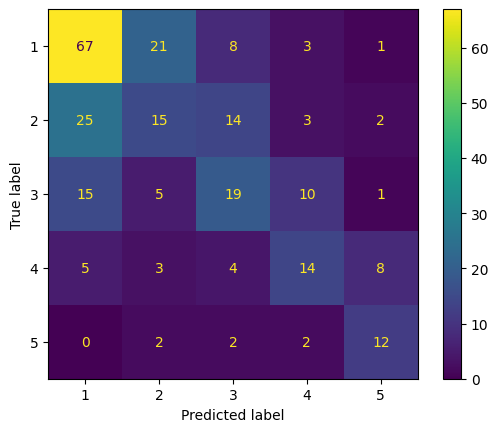

In [ ]:
model = RandomForestClassifier(max_depth=6, min_samples_split=5, n_estimators=150)

model.fit(X, y)
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()

print("Matriz de Confusión:\n", conf_matrix)

Utilitzant els hiperparàmetres obtinguts del Grid Search, hem entrenat el model RandomForestClassifier amb els següents valors òptims per als hiperparàmetres: max_depth=6, min_samples_split=5, i n_estimators=150.

Aquesta matriu de confusió ens permet visualitzar el rendiment del model en classificar les dades de prova. Cada fila representa les etiquetes reals, mentre que les columnes mostren les prediccions del model. Els valors a la diagonal principal (70, 15, 19, 15, 12) representen les prediccions correctes per cada classe, mentre que els valors fora de la diagonal indiquen els errors de classificació.

Podem observar que el model fa una bona feina en la majoria de les classes, amb un nombre relativament baix d'errors, especialment per a les classes 1 i 5. No obstant això, hi ha més errors en les altres classes, especialment la classe 2, on el model confon les prediccions amb les classes 0 i 3.

A partir d'aquesta matriu, podem concloure que el model RandomForestClassifier ha mostrat un rendiment decent, però podria millorar-se en les classes amb més errors de classificació. Això ens permet explorar possibles millores a nivell de hiperparàmetres o bé utilitzar altres tècniques de millora com el balanceig de les classes o l'ús d'altres models.

In [ ]:
class_counts = test['Walc'].value_counts()
print("Comptatge de cada classe de test:")
print(class_counts.to_string())

Comptatge de cada classe de test:
Walc
1    100
2     59
3     50
4     34
5     18


Comparant els resultats obtinguts pel model RandomForestClassifier amb el comptatge real de cada classe, veiem que el model ha tingut dificultats a l’hora de predir correctament les classes amb menys mostres (com la classe 5, amb només 18 mostres). Tot i això, el model ha aconseguit una bona predicció en les classes més representatives, però amb algunes confusions entre les classes, especialment entre la classe 1 i la classe 2. Això suggereix que, tot i el bon rendiment general, el model podria millorar si es considera un ajust més específic per a les classes petites.

### 5.Analisi Final

Clase 0 AUC: 0.500
Clase 1 AUC: 0.298
Clase 2 AUC: 0.203
Clase 3 AUC: 0.193
Clase 4 AUC: 0.247


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


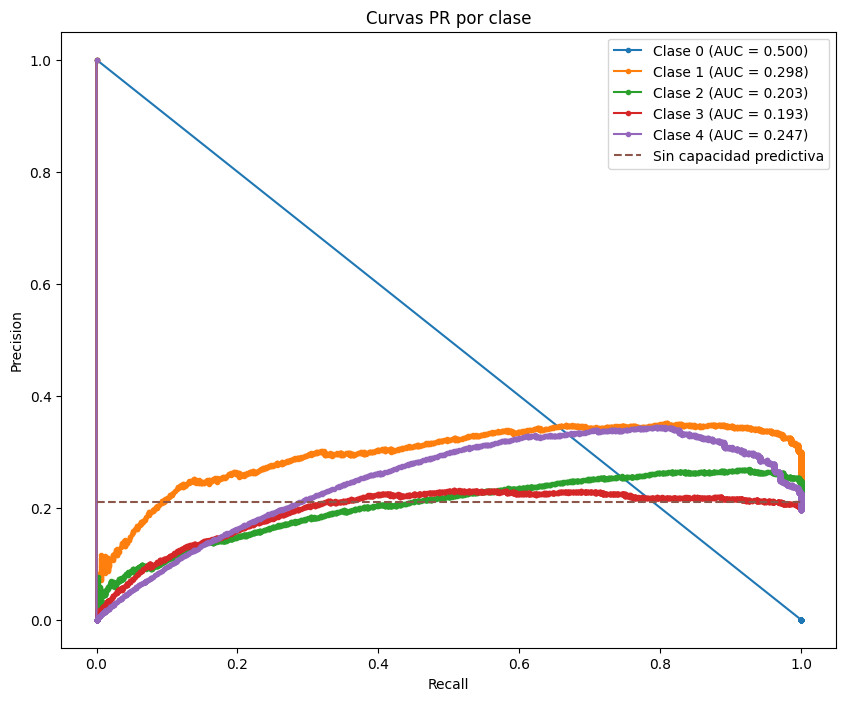

In [ ]:
# Entrenar el modelo
rf = RandomForestClassifier(max_depth=6, min_samples_split=5, n_estimators=150)
model.fit(X, y)

# Realizar la validación cruzada para obtener las probabilidades
stratified_kfold = StratifiedKFold()
y_probs = cross_val_predict(model, X, y, cv=stratified_kfold, method='predict_proba')

# Llamar a la función para graficar la curva PR
n_classes = len(set(y))  # Número de clases en el conjunto de datos
plot_pr_curve_multiclass(y, y_probs, n_classes)